In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
covid_19_df = pd.read_csv('covid_19_clean_complete.csv', parse_dates=True, dayfirst=False)

In [5]:
covid_19_df = pd.read_csv('covid_19_clean_complete.csv')
covid_19_df['Date'] = pd.to_datetime(covid_19_df['Date'])
covid_19_df['Country/Region'] = covid_19_df['Country/Region'].replace('Mainland China', 'China')
covid_19_df.tail(2)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
15870,Yukon,Canada,64.282300,-135.000000,2020-03-25,0,0,NaN
15871,NaN,Kosovo,42.602636,20.902977,2020-03-25,0,0,0.0


In [8]:
cases = ['Confirmed', 'Active', 'Recovered', 'Deaths']
growth = ['Confirmed_growth', 'Deaths_growth', 'Recovered_growth', 'Confirmed_growth_mean']
covid_19_df['Active'] = covid_19_df['Confirmed'] - covid_19_df['Deaths'] - covid_19_df['Recovered']
covid_19_df = covid_19_df.sort_values(by=['Date'], ascending=True)
covid_19_df.head(2)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
0,NaN,Afghanistan,33.0,65.0,2020-01-22,0,0,0.0,0.0
157,NaN,Mauritius,-20.2,57.5,2020-01-22,0,0,0.0,0.0


### Finding Countries with most confirmed cases

In [9]:
last_covid_df = covid_19_df[covid_19_df['Date'] == covid_19_df['Date'].max()].reset_index(drop=True)
last_covid_df = last_covid_df.drop(columns=['Lat', 'Long'])
top_50 = last_covid_df.groupby('Country/Region').sum().sort_values(by='Confirmed', ascending=False).head(50)
grouped_Poland = top_50[top_50.index == "Poland"]
top_10 = last_covid_df.groupby('Country/Region').sum().sort_values(by='Confirmed', ascending=False).head(10)
top_10_with_Poland  = pd.concat([top_10, grouped_Poland])

In [10]:
def prepare_data(df, country, *lower_bound):
    df = df[df['Country/Region'] == country]
    if (country == 'China') | (country == 'US') | (country == 'Australia') | (country == 'Canada') | (country == 'Denmark') | (country == 'France'):
        df = df.groupby('Date').sum().reset_index()
    elif df[df['Province/State'] == country].notna().any().any():
        df = df[df['Province/State'] == country]
    df = df.sort_values(by='Date').reset_index(drop=True)

    if lower_bound:
        df = df[df.Confirmed > lower_bound].reset_index(drop=True)
    date_range = df['Date'].sort_values().drop_duplicates().reset_index(drop=True)
    date_range = date_range.dt.strftime('%d-%m')
    return df, date_range

In [11]:
def show_increment(df, label, date_range):
    my_xticks = range(0, len(date_range), 5)
    my_xticks_labels = list(date_range)[0:len(date_range):5]
    
    fig, ax = plt.subplots(figsize=(7, 5))
    ax1 = sns.lineplot(data=df[cases], ax=ax)
    ax1.set_xticks(my_xticks)
    ax1.set_xticklabels(my_xticks_labels)
    ax1.set_xlabel(label)
    plt.show()
    
    print('\nDaily growth for each types of cases\n')
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(23, 5))
    ax1 = sns.barplot(x=date_range.index, y='Confirmed_growth', data=df, ax=ax1, palette=cm.Blues(df.Confirmed_growth/max(df.Confirmed_growth*1.5)+0.3))
    ax1.set_xticks(my_xticks)
    ax1.set_xticklabels(my_xticks_labels)
    ax1.set_xlabel('Daily Confirmed growth')
    ax1.set_ylabel('Cases')
    
    ax2 = sns.barplot(x=date_range.index, y='Deaths_growth', data=df, ax=ax2, palette=cm.autumn_r(df.Deaths_growth/max(df.Deaths_growth*1.5)+0.3))
    ax2.set_xticks(my_xticks)
    ax2.set_xticklabels(my_xticks_labels)
    ax2.set_xlabel('Daily Deaths growth')
    ax2.set_ylabel('Cases')
    
    ax3 = sns.barplot(x=date_range.index, y='Recovered_growth', data=df, ax=ax3, palette=cm.Greens(df.Recovered_growth/max(df.Recovered_growth)+0.3))
    ax3.set_xticks(my_xticks)
    ax3.set_xticklabels(my_xticks_labels)
    ax3.set_xlabel('Daily Recovered growth')
    ax3.set_ylabel('Cases')
    
    plt.show()

In [12]:
def add_data(covid_19_df):
    covid_19_df['Confirmed_growth'] = covid_19_df['Confirmed'] - covid_19_df['Confirmed'].shift()
    covid_19_df['Confirmed_growth'][0] = covid_19_df['Confirmed'][0]
    covid_19_df = covid_19_df.fillna(0)

    covid_19_df['Deaths_growth'] = covid_19_df['Deaths'] - covid_19_df['Deaths'].shift()
    covid_19_df['Deaths_growth'][0] = covid_19_df['Deaths'][0]
    covid_19_df = covid_19_df.fillna(0)

    covid_19_df['Recovered_growth'] = covid_19_df['Recovered'] - covid_19_df['Recovered'].shift()
    covid_19_df['Recovered_growth'][0] = covid_19_df['Recovered'][0]
    covid_19_df = covid_19_df.fillna(0)
    return covid_19_df

### Plot for 10 countries with most confirmed cases with start data: 50 confirmed cases<br> on one plot

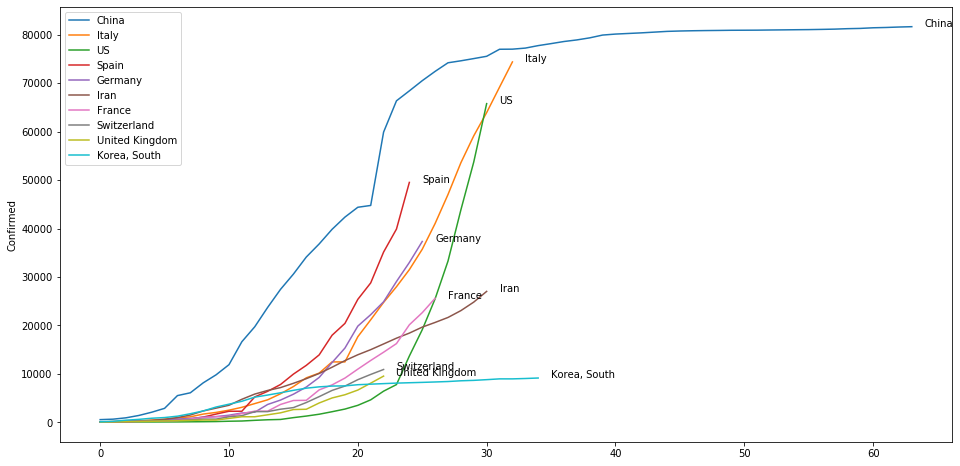

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))

for index, country in enumerate(top_10.index):
    df, date_range = prepare_data(covid_19_df, country, 50)
    x=df.index
    y=df.Confirmed    
    ax = sns.lineplot(x=x, y=y, data=df, label=country)
    last = len(y)
    ax.text(last, y.iloc[last-1], country, horizontalalignment='left', size='medium', color='black')

plt.show()

### Plot for 10 countries with most confirmed cases with start data: 100 confirmed cases<br> on one plot without China and Italy

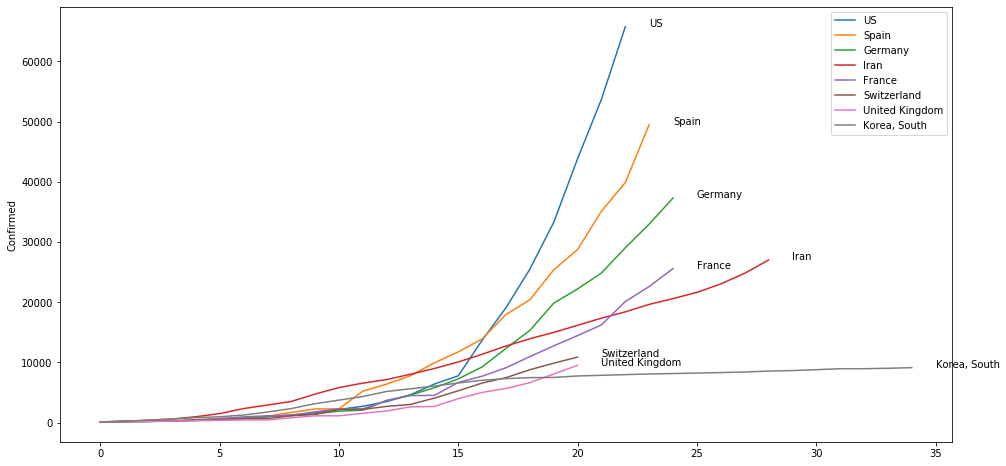

In [14]:
fig, ax = plt.subplots(figsize=(16, 8))
for index, country in enumerate(top_10.index[2:10]):
    df, date_range = prepare_data(covid_19_df, country, 100)
    x=df.index
    y=df.Confirmed
    ax = sns.lineplot(x=df.index, y=df.Confirmed, data=df, label=country)
    last = len(y)
    ax.text(last, y.iloc[last-1], country, horizontalalignment='left', size='medium', color='black')
plt.show()

### Plot for 10 countries with most confirmed cases with start data: 100 confirmed cases<br> on one plot with Poland

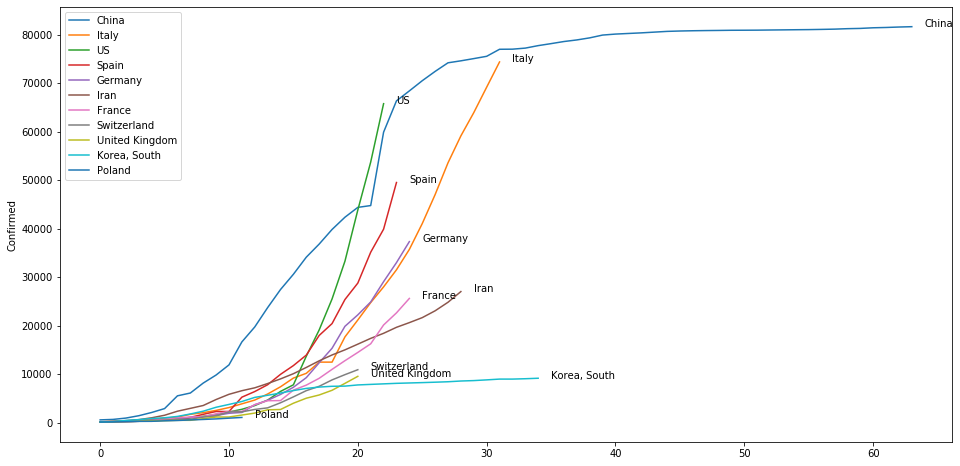

In [15]:
fig, ax = plt.subplots(figsize=(16, 8))
for index, country in enumerate(top_10_with_Poland.index):
    df, date_range = prepare_data(covid_19_df, country, 100)
    x=df.index
    y=df.Confirmed
    ax = sns.lineplot(x=df.index, y=df.Confirmed, data=df, label=country)
    last = len(y)
    ax.text(last, y.iloc[last-1], country, horizontalalignment='left', size='medium', color='black')
    
plt.show()

### Plot for 10 countries with most confirmed cases with start data: 100 confirmed cases<br> on one plot without China & Italy with Poland

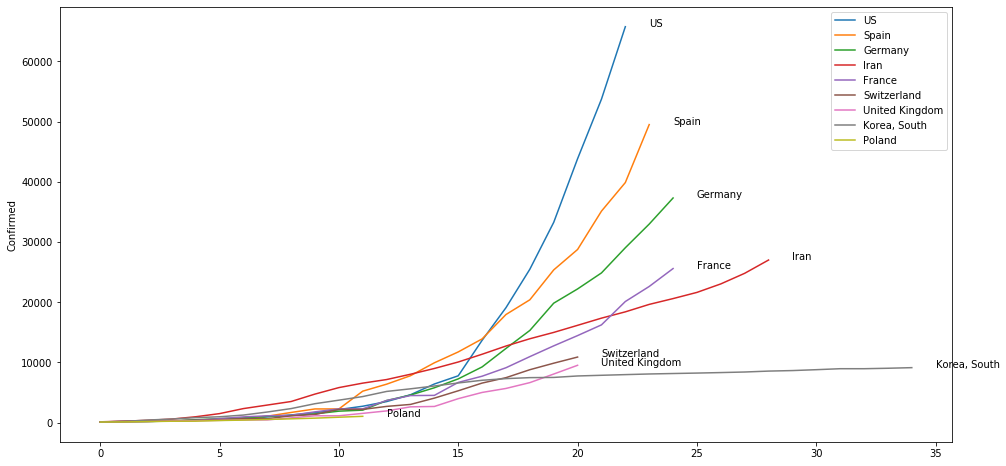

In [16]:
fig, ax = plt.subplots(figsize=(16, 8))
for index, country in enumerate(top_10_with_Poland.index[2:]):
    df, date_range = prepare_data(covid_19_df, country, 100)
    x=df.index
    y=df.Confirmed
    ax = sns.lineplot(x=df.index, y=df.Confirmed, data=df, label=country)
    last = len(y)
    ax.text(last, y.iloc[last-1], country, horizontalalignment='left', size='medium', color='black')
    
plt.show()

### Plots for 50 countries with most confirmed cases with start data: 50 confirmed cases

The line plot presents all data in the following days starting from the moment when there were more than 50 confirmed cases.<br>
The bar plots show the daily increase in each category. There are some days with negative values caused by changes in the data tables in the source data - maybe some of the cases were wrongly classified as recovered and therefore were removed. 

1 . China
Confirmed: 81661 
Active: 4603.0 
Recovered: 73773.0 
Deaths: 3285


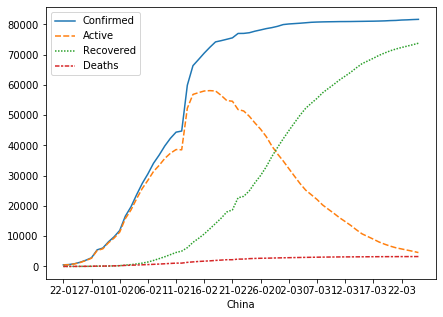


Daily growth for each types of cases



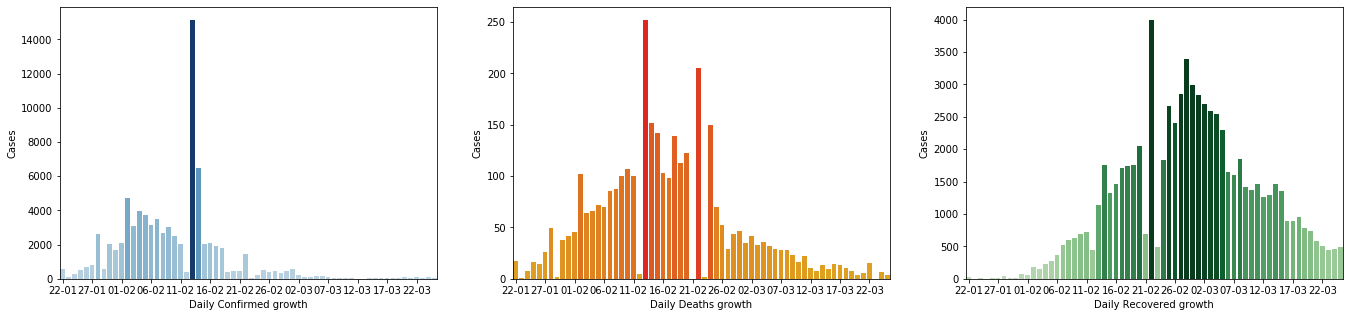

2 . Italy
Confirmed: 74386 
Active: 57521.0 
Recovered: 9362.0 
Deaths: 7503


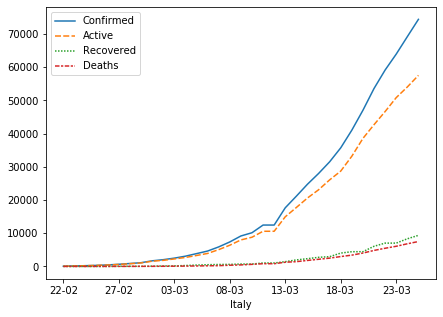


Daily growth for each types of cases



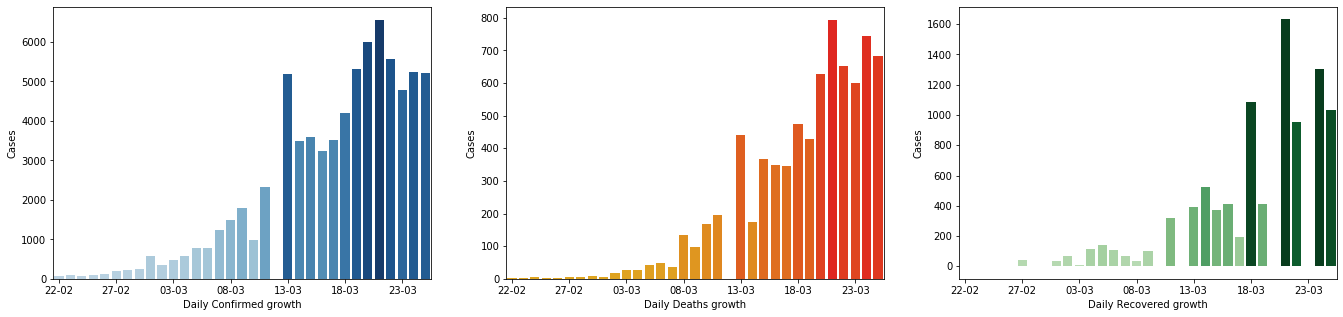

3 . US
Confirmed: 65778 
Active: 64475.0 
Recovered: 361.0 
Deaths: 942


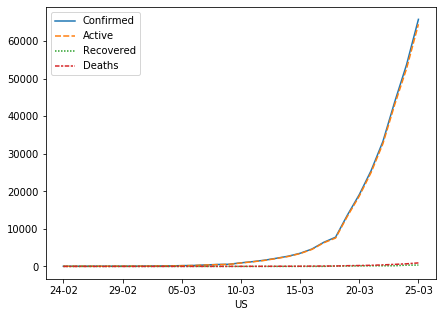


Daily growth for each types of cases



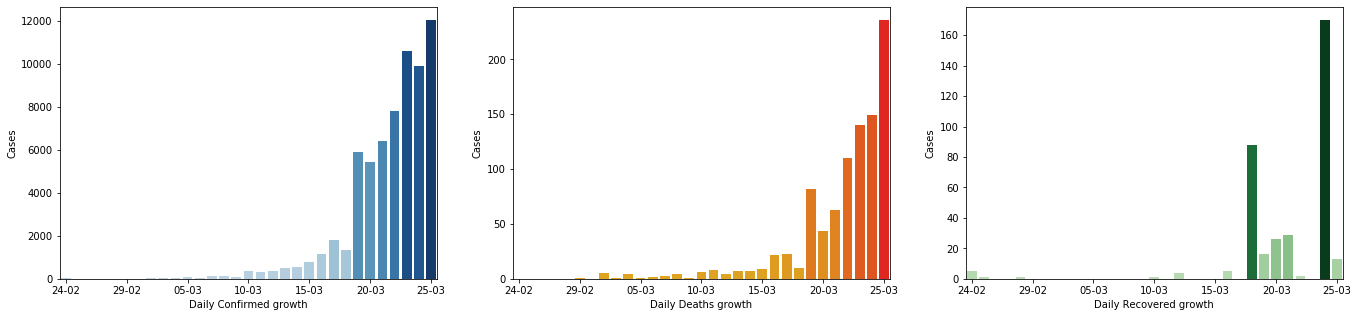

4 . Spain
Confirmed: 49515 
Active: 40501.0 
Recovered: 5367.0 
Deaths: 3647


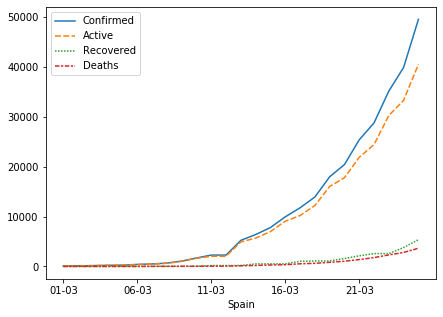


Daily growth for each types of cases



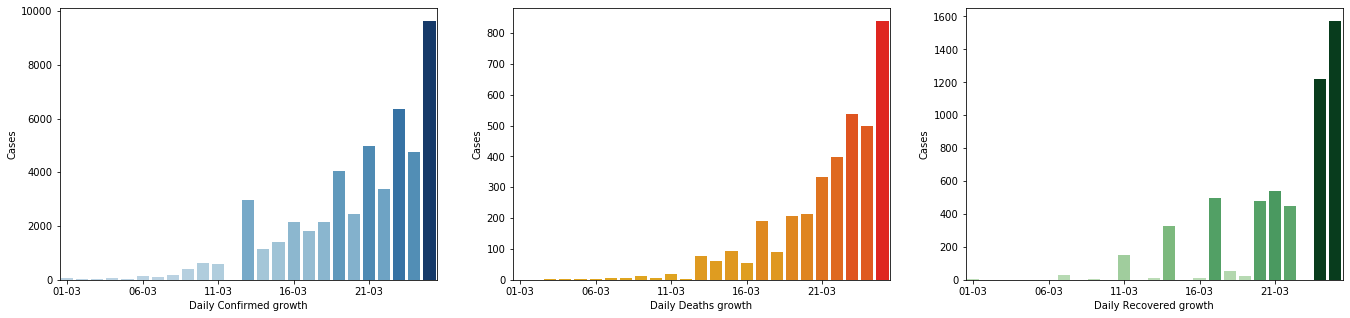

5 . Germany
Confirmed: 37323 
Active: 33570.0 
Recovered: 3547.0 
Deaths: 206


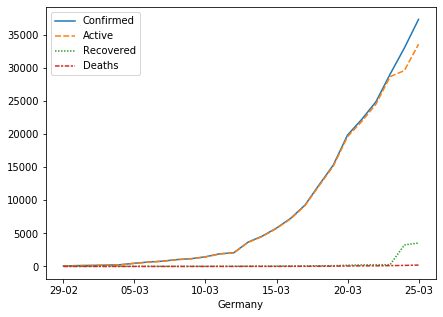


Daily growth for each types of cases



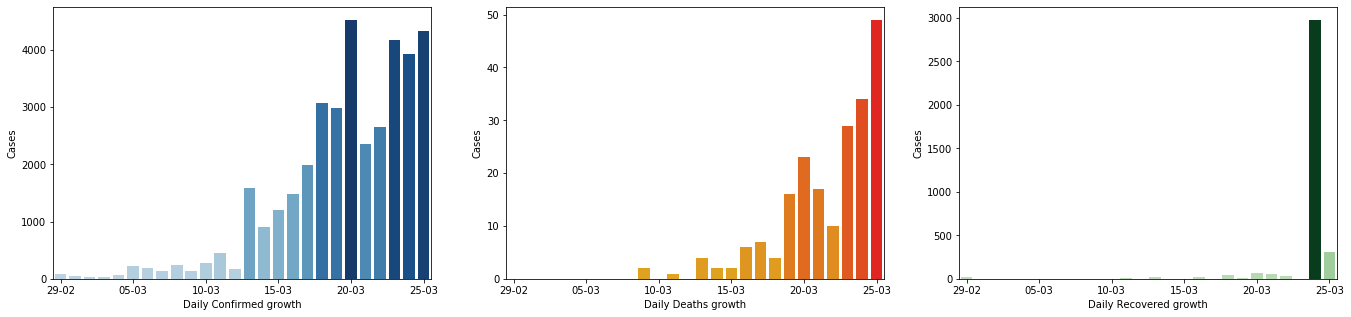

6 . Iran
Confirmed: 27017 
Active: 15315.0 
Recovered: 9625.0 
Deaths: 2077


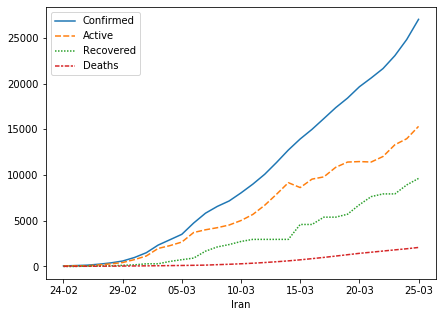


Daily growth for each types of cases



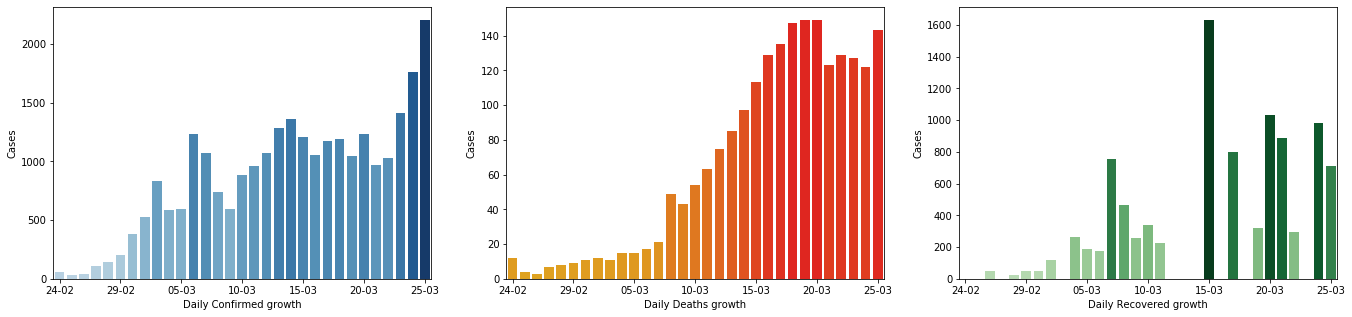

7 . France
Confirmed: 25600 
Active: 20360.0 
Recovered: 3907.0 
Deaths: 1333


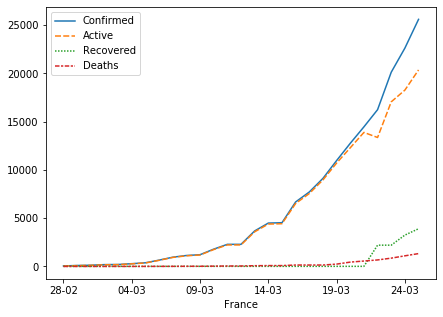


Daily growth for each types of cases



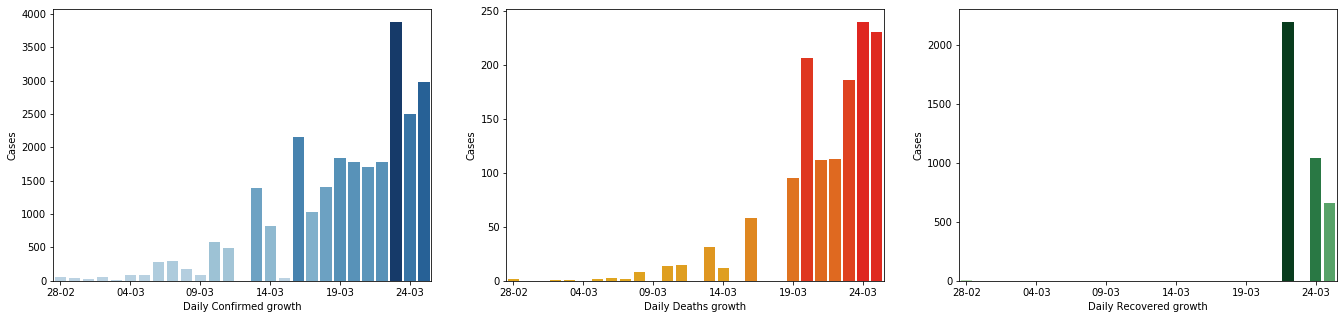

8 . Switzerland
Confirmed: 10897 
Active: 10613.0 
Recovered: 131.0 
Deaths: 153


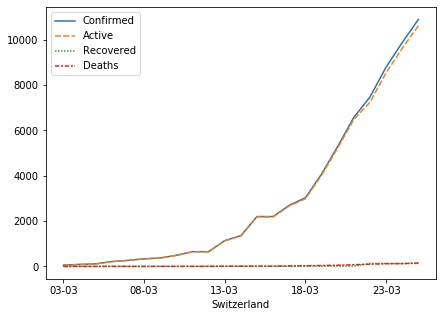


Daily growth for each types of cases



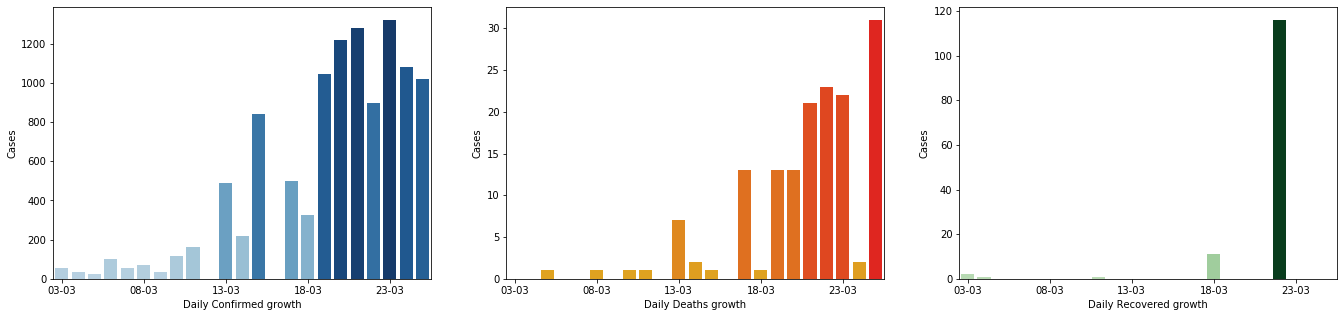

9 . United Kingdom
Confirmed: 9640 
Active: 9034.0 
Recovered: 140.0 
Deaths: 466


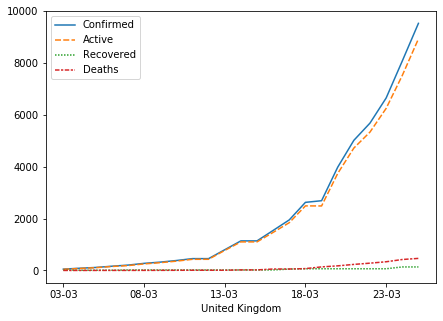


Daily growth for each types of cases



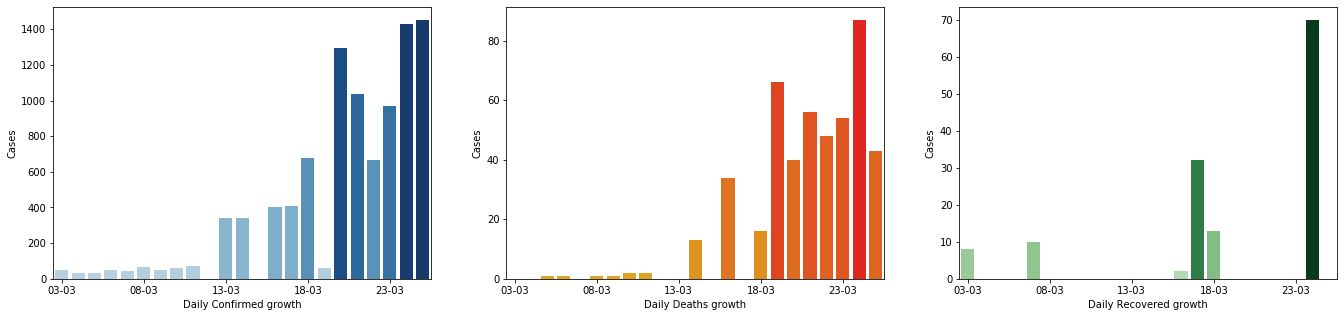

10 . Korea, South
Confirmed: 9137 
Active: 5281.0 
Recovered: 3730.0 
Deaths: 126


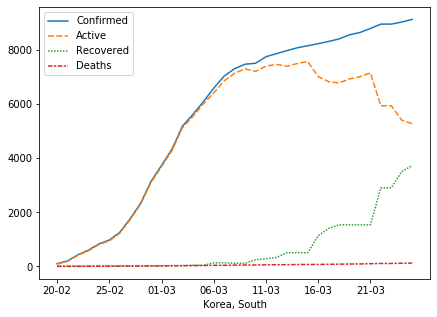


Daily growth for each types of cases



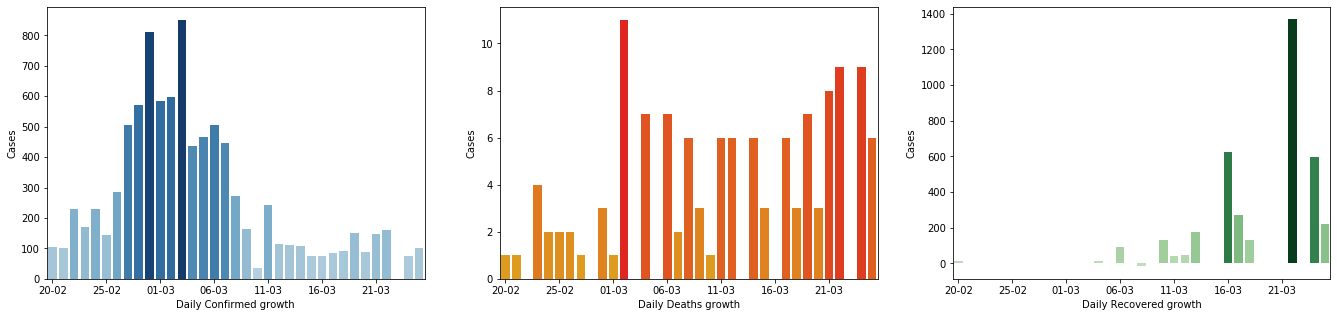

11 . Netherlands
Confirmed: 6438 
Active: 6077.0 
Recovered: 4.0 
Deaths: 357


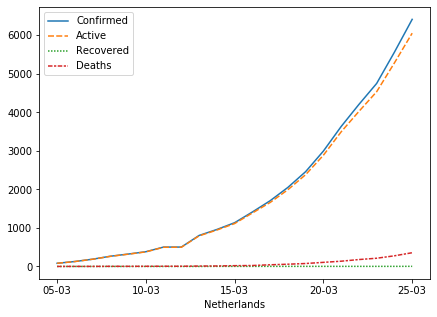


Daily growth for each types of cases



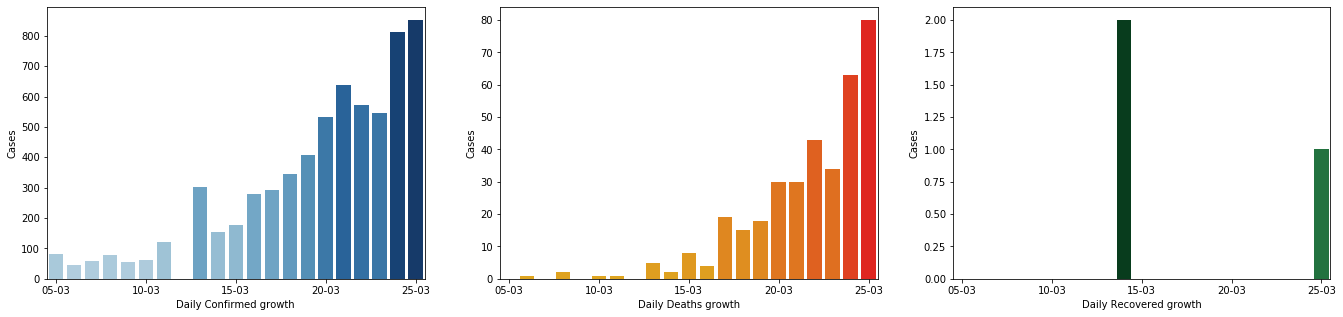

12 . Austria
Confirmed: 5588 
Active: 5549.0 
Recovered: 9.0 
Deaths: 30


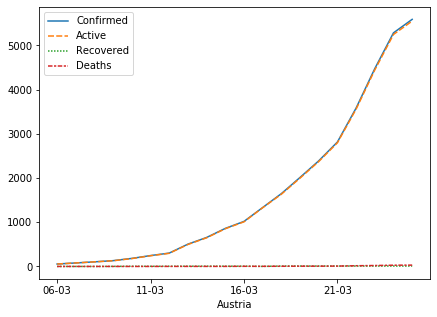


Daily growth for each types of cases



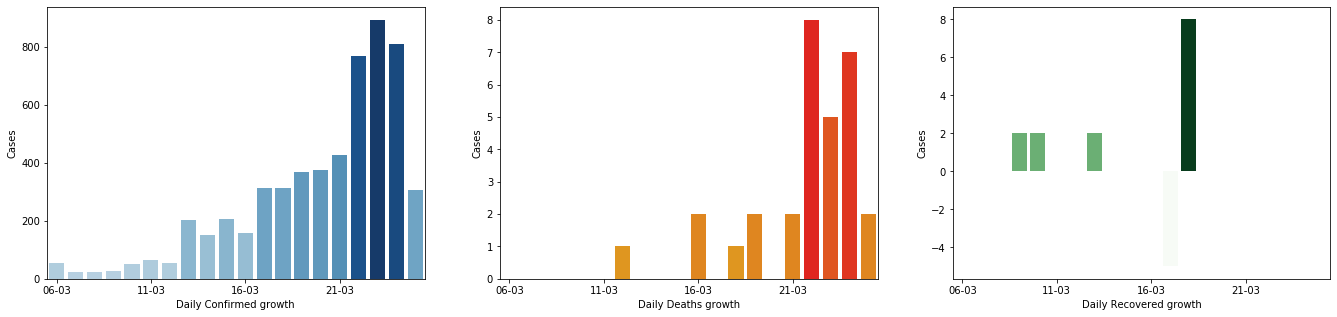

13 . Belgium
Confirmed: 4937 
Active: 4212.0 
Recovered: 547.0 
Deaths: 178


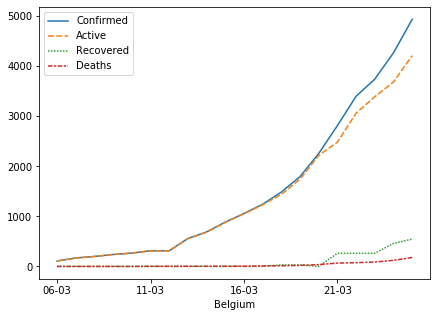


Daily growth for each types of cases



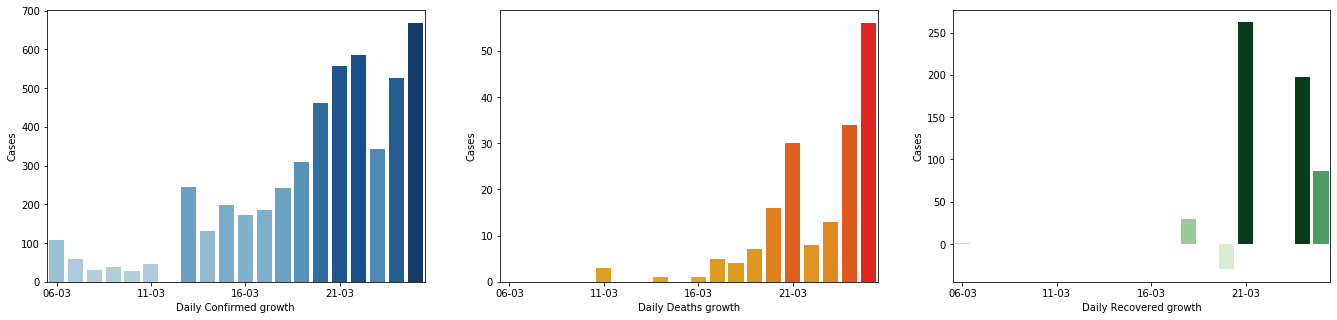

14 . Canada
Confirmed: 3251 
Active: 0.0 
Recovered: 0.0 
Deaths: 30


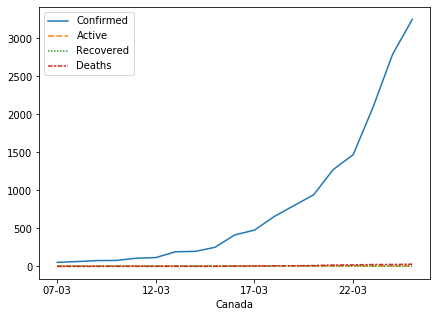


Daily growth for each types of cases



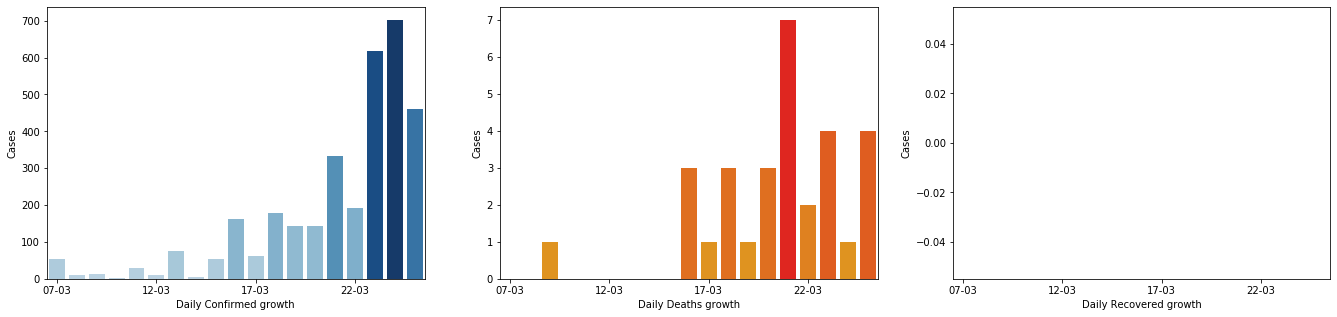

15 . Norway
Confirmed: 3084 
Active: 3064.0 
Recovered: 6.0 
Deaths: 14


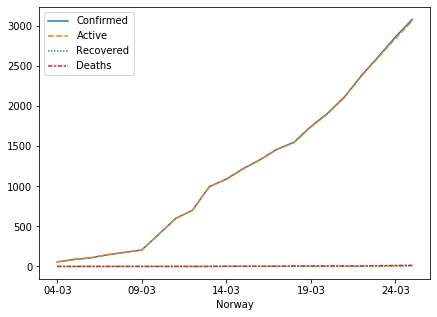


Daily growth for each types of cases



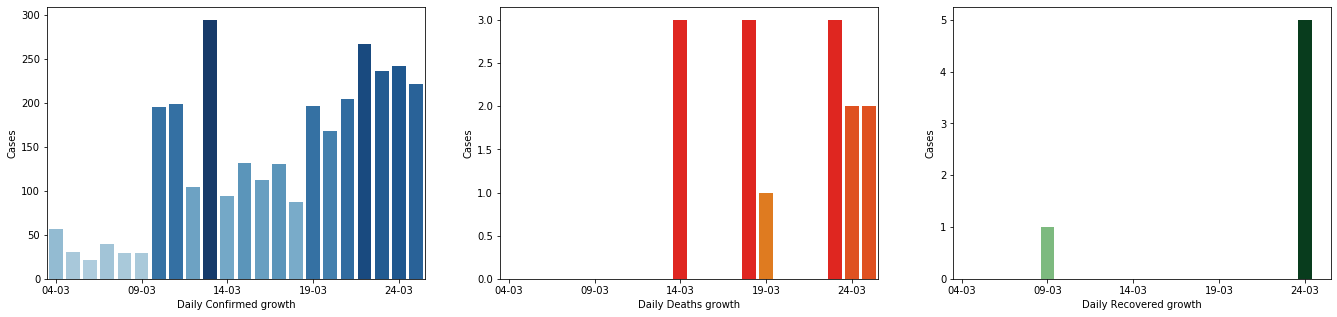

16 . Portugal
Confirmed: 2995 
Active: 2930.0 
Recovered: 22.0 
Deaths: 43


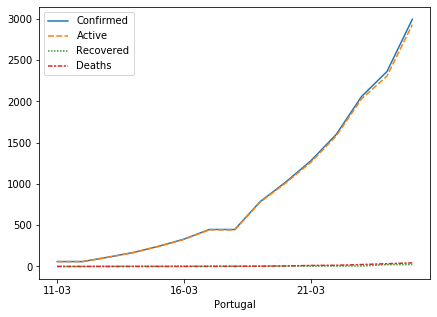


Daily growth for each types of cases



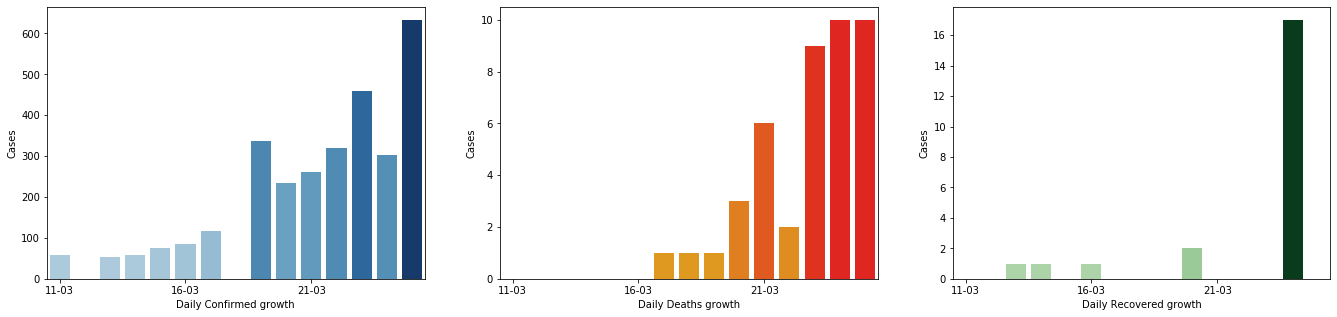

17 . Brazil
Confirmed: 2554 
Active: 2493.0 
Recovered: 2.0 
Deaths: 59


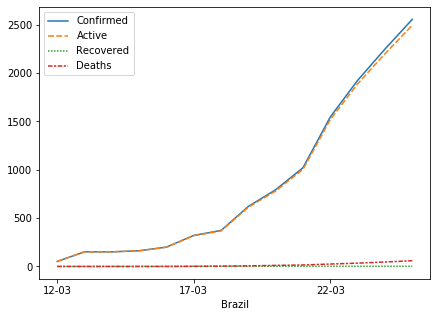


Daily growth for each types of cases



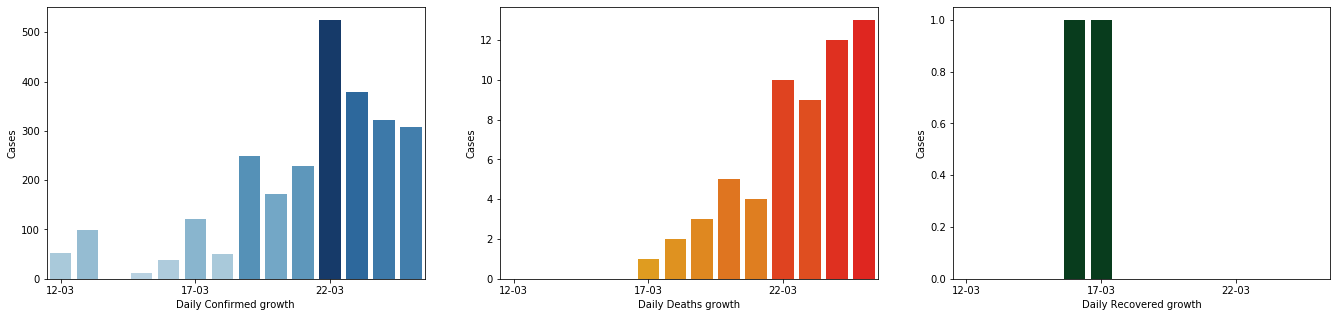

18 . Sweden
Confirmed: 2526 
Active: 2448.0 
Recovered: 16.0 
Deaths: 62


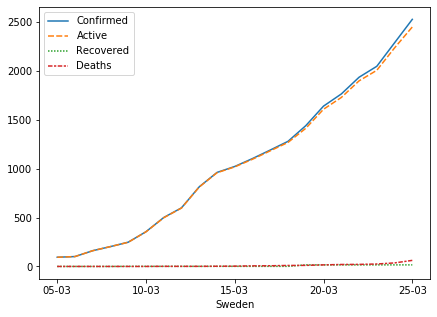


Daily growth for each types of cases



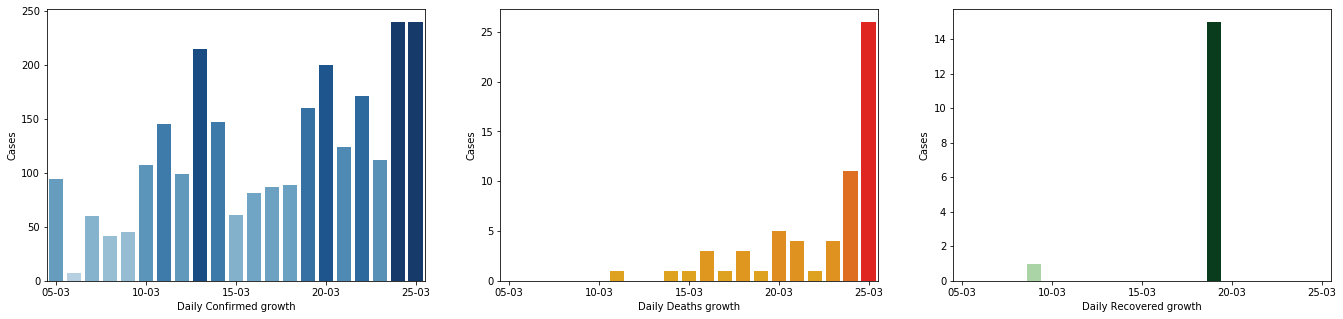

19 . Turkey
Confirmed: 2433 
Active: 2348.0 
Recovered: 26.0 
Deaths: 59


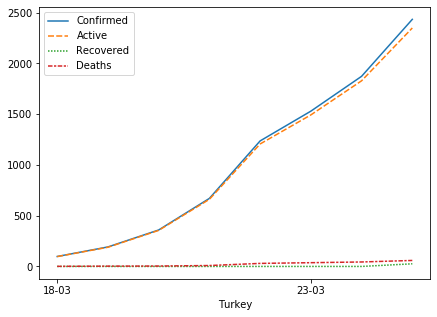


Daily growth for each types of cases



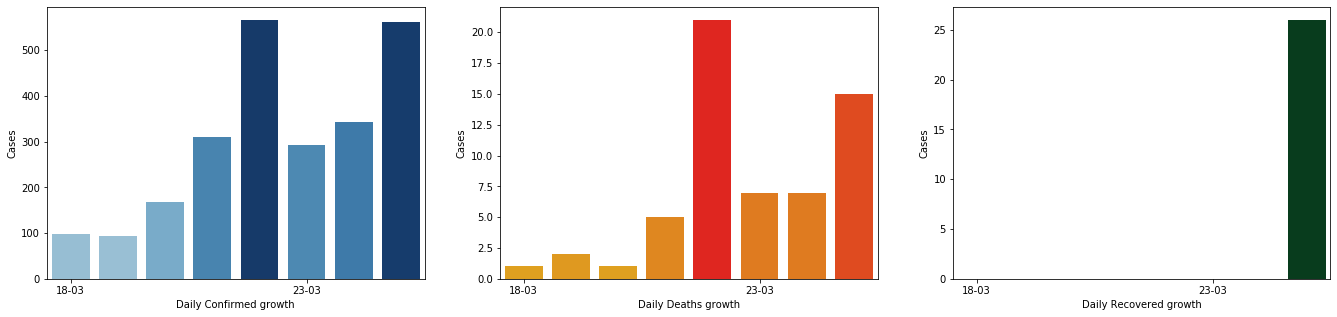

20 . Israel
Confirmed: 2369 
Active: 2306.0 
Recovered: 58.0 
Deaths: 5


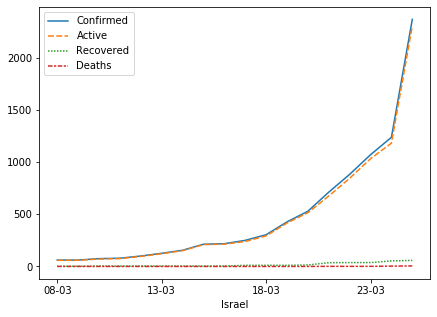


Daily growth for each types of cases



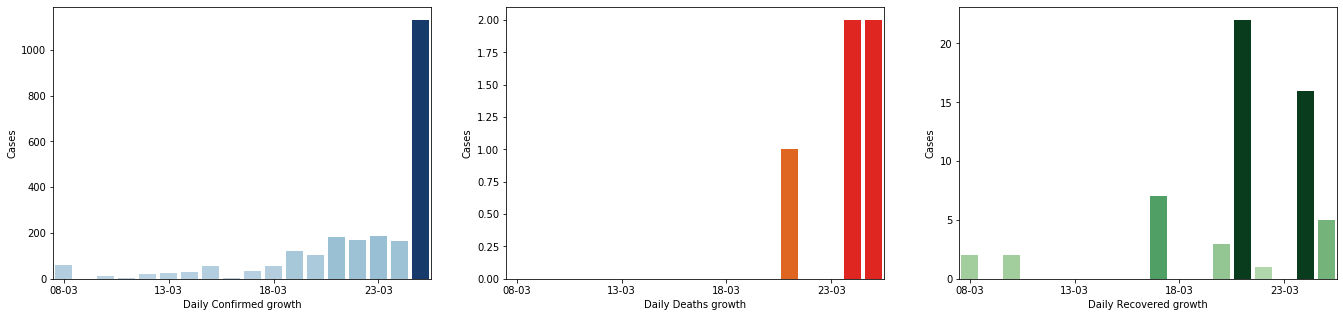

21 . Australia
Confirmed: 2364 
Active: 2237.0 
Recovered: 119.0 
Deaths: 8


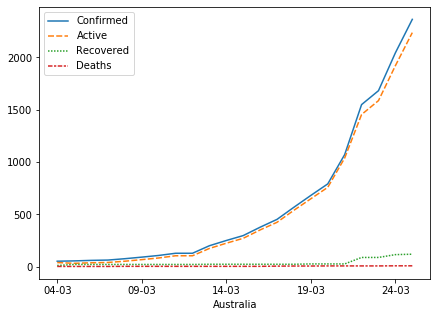


Daily growth for each types of cases



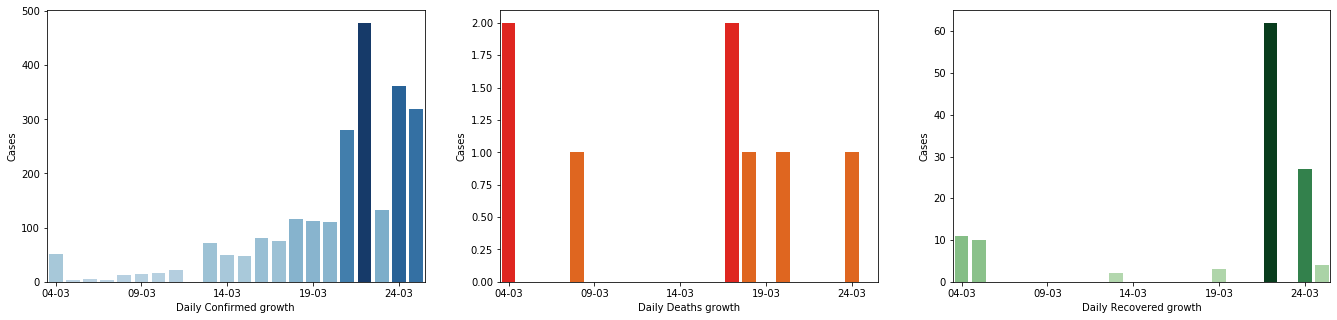

22 . Denmark
Confirmed: 1862 
Active: 1787.0 
Recovered: 41.0 
Deaths: 34


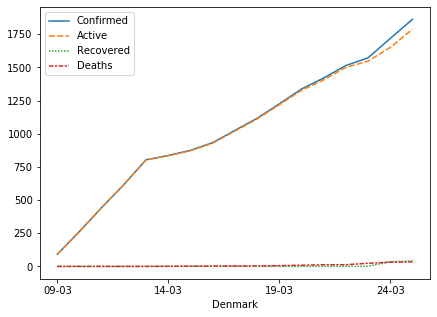


Daily growth for each types of cases



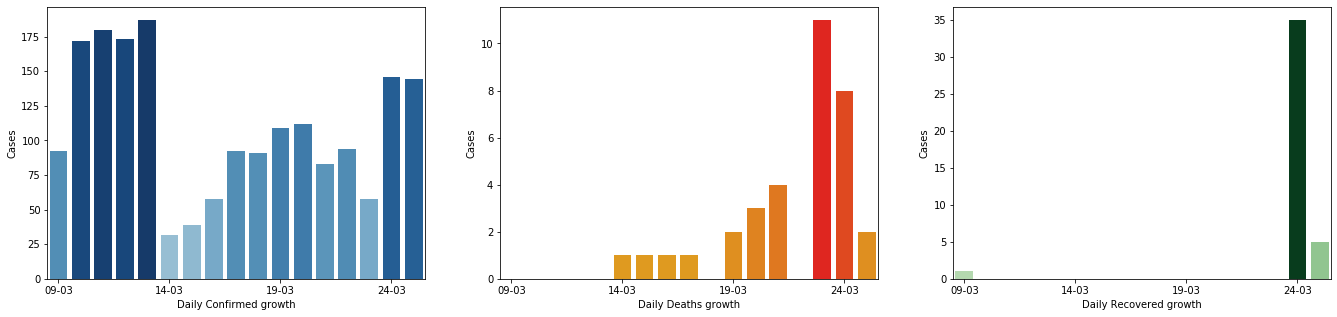

23 . Malaysia
Confirmed: 1796 
Active: 1577.0 
Recovered: 199.0 
Deaths: 20


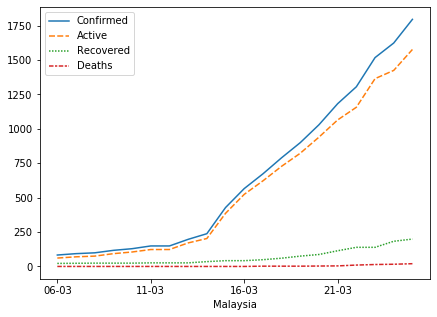


Daily growth for each types of cases



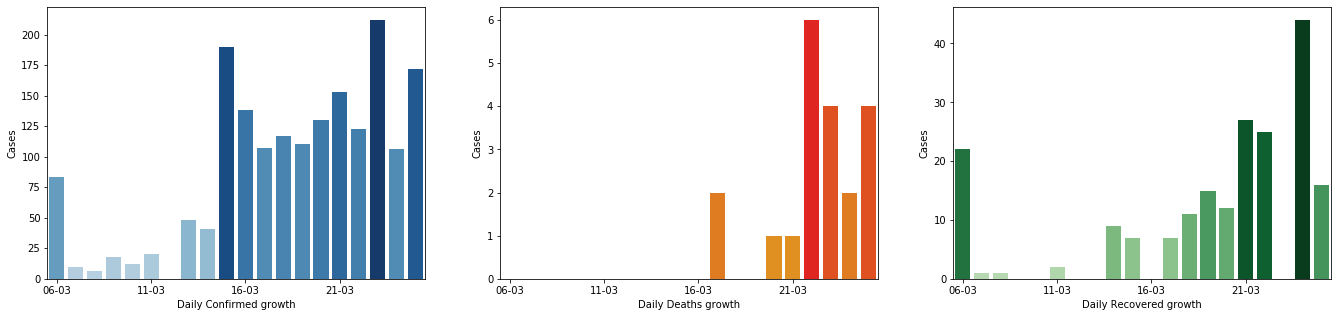

24 . Czechia
Confirmed: 1654 
Active: 1638.0 
Recovered: 10.0 
Deaths: 6


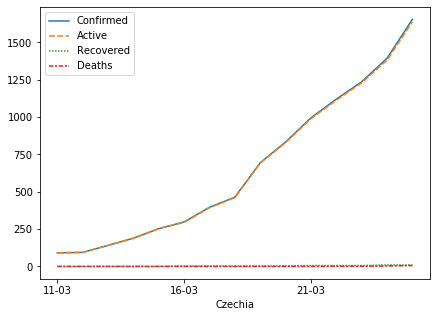


Daily growth for each types of cases



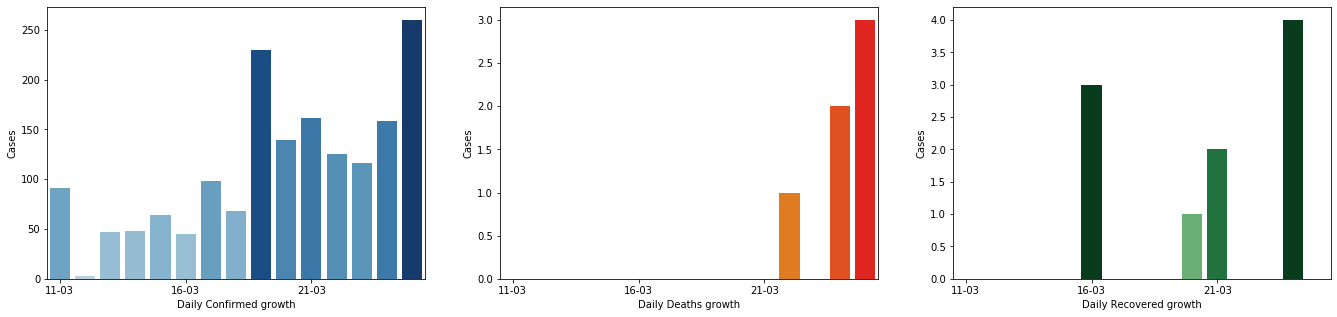

25 . Ireland
Confirmed: 1564 
Active: 1550.0 
Recovered: 5.0 
Deaths: 9


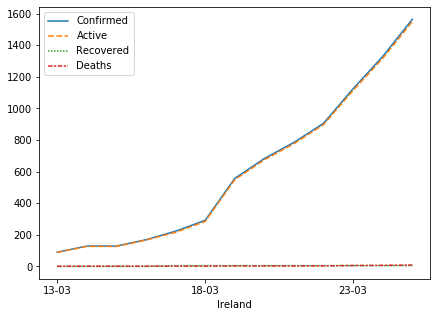


Daily growth for each types of cases



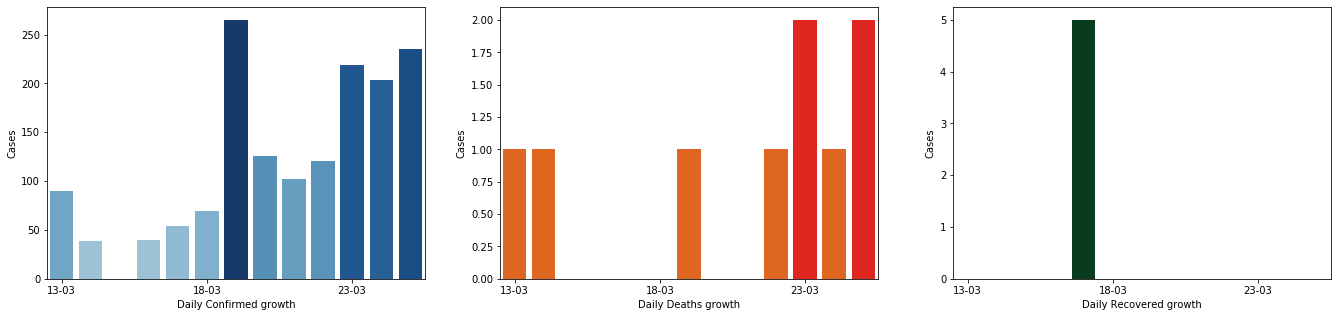

26 . Luxembourg
Confirmed: 1333 
Active: 1319.0 
Recovered: 6.0 
Deaths: 8


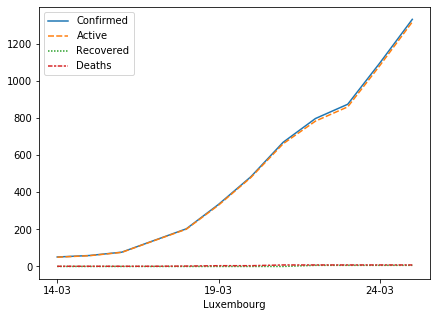


Daily growth for each types of cases



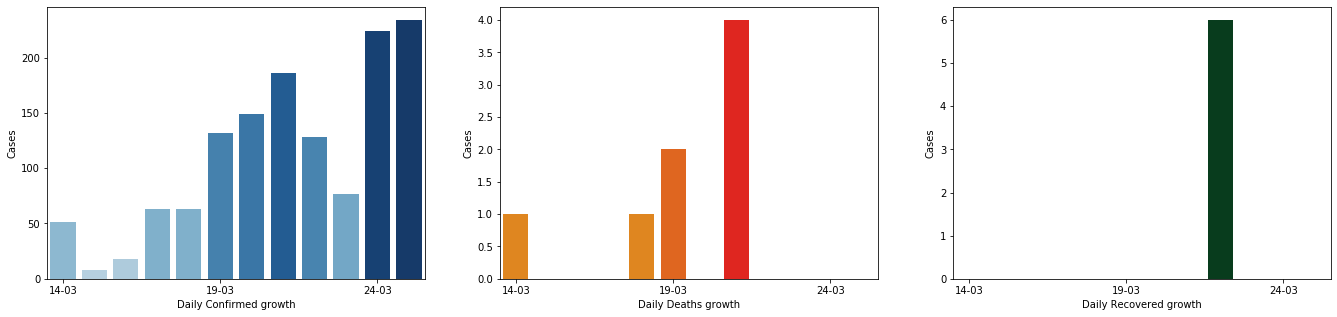

27 . Japan
Confirmed: 1307 
Active: 952.0 
Recovered: 310.0 
Deaths: 45


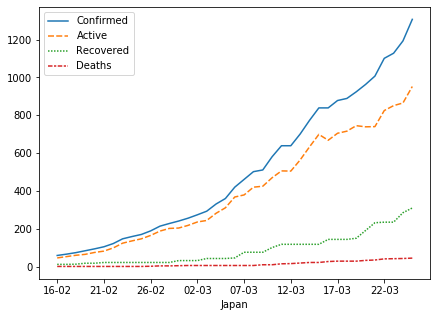


Daily growth for each types of cases



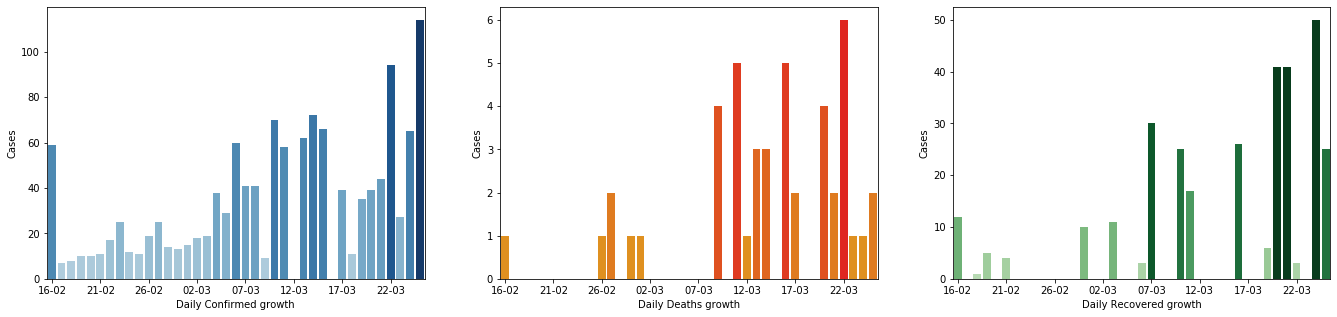

28 . Ecuador
Confirmed: 1173 
Active: 1142.0 
Recovered: 3.0 
Deaths: 28


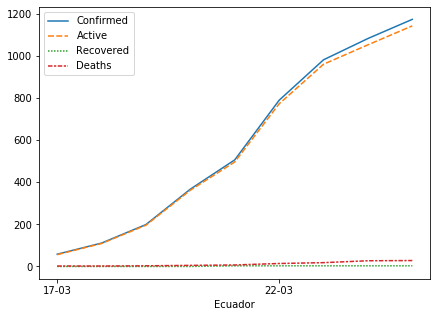


Daily growth for each types of cases



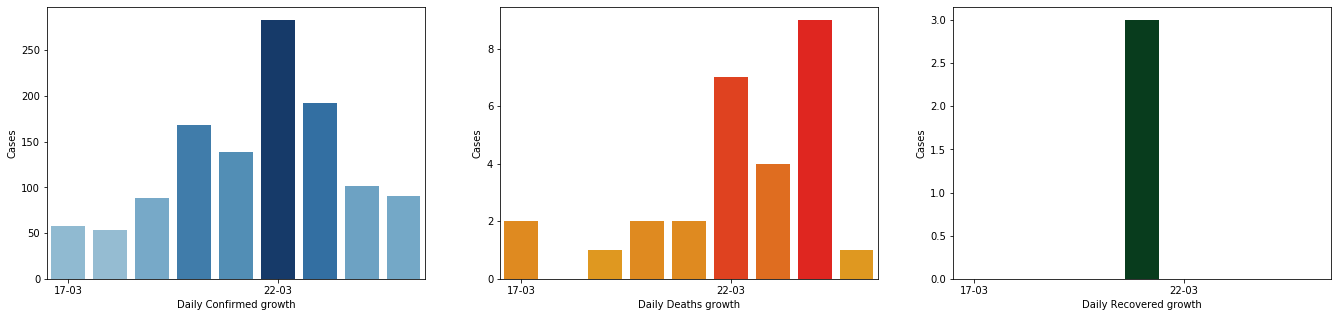

29 . Chile
Confirmed: 1142 
Active: 1117.0 
Recovered: 22.0 
Deaths: 3


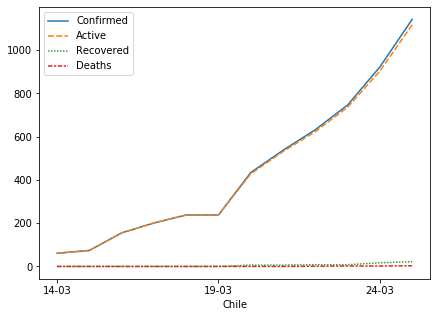


Daily growth for each types of cases



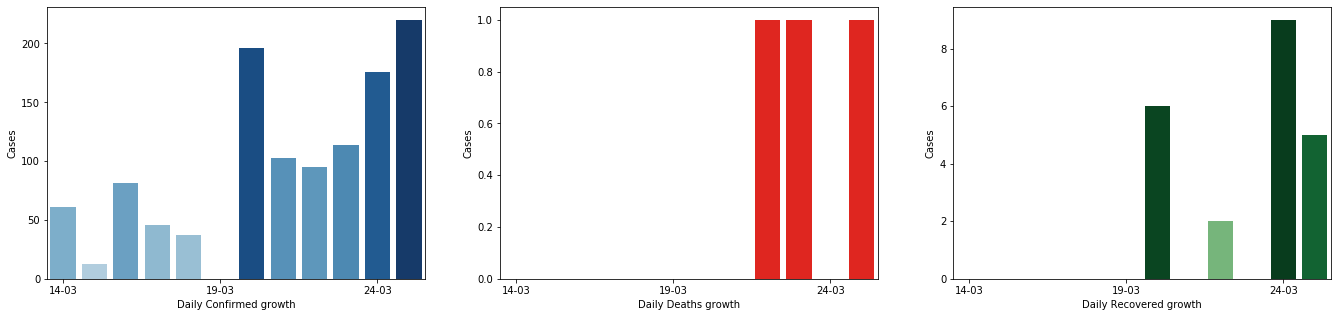

30 . Pakistan
Confirmed: 1063 
Active: 1034.0 
Recovered: 21.0 
Deaths: 8


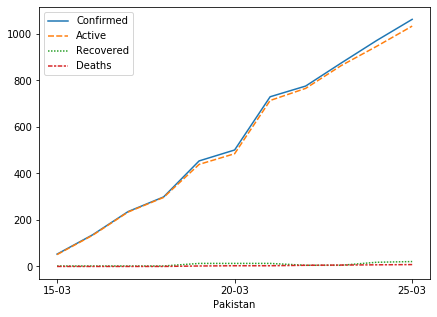


Daily growth for each types of cases



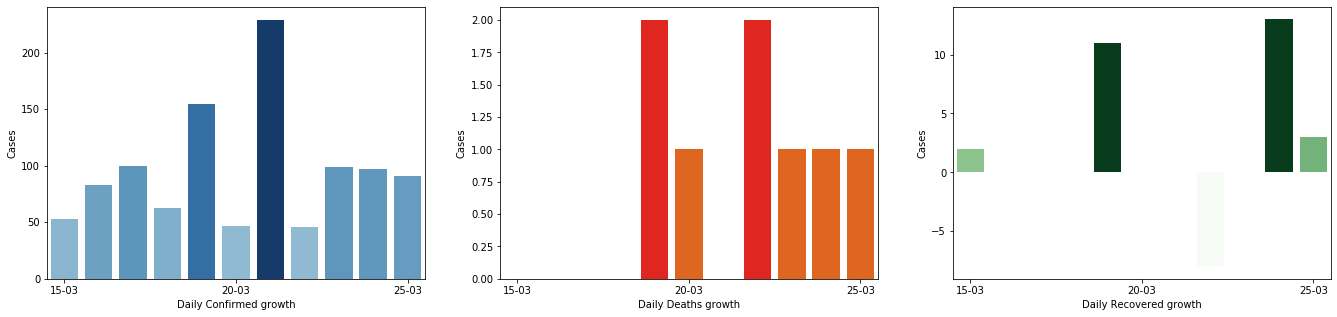

31 . Poland
Confirmed: 1051 
Active: 1030.0 
Recovered: 7.0 
Deaths: 14


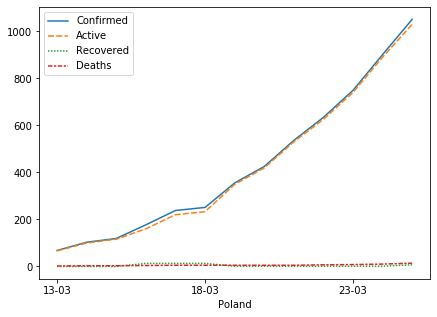


Daily growth for each types of cases



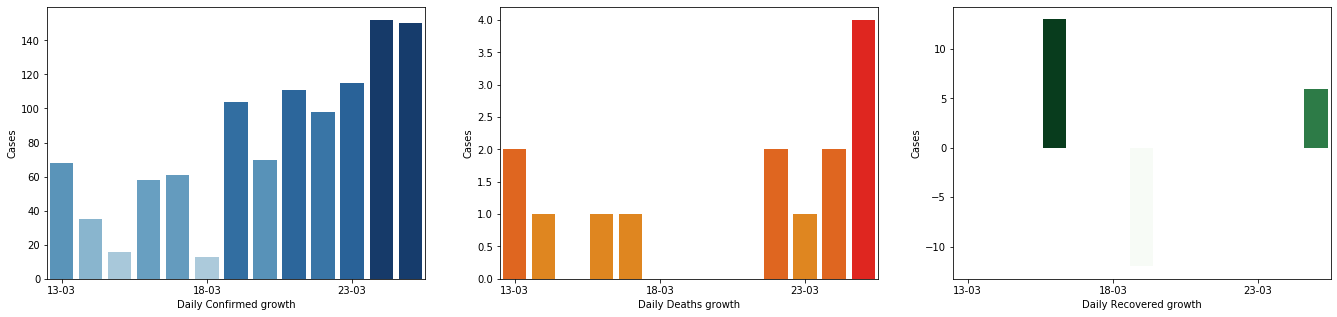

32 . Thailand
Confirmed: 934 
Active: 860.0 
Recovered: 70.0 
Deaths: 4


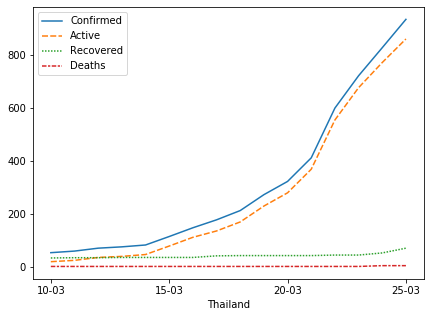


Daily growth for each types of cases



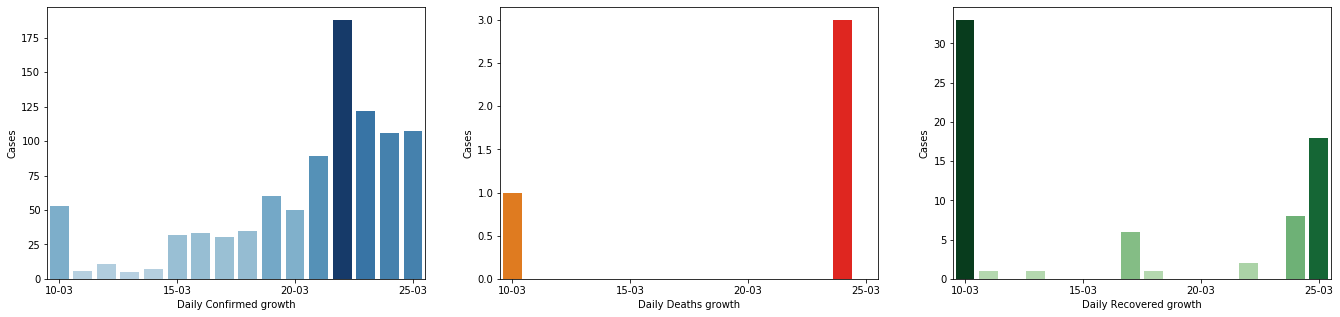

33 . Romania
Confirmed: 906 
Active: 803.0 
Recovered: 86.0 
Deaths: 17


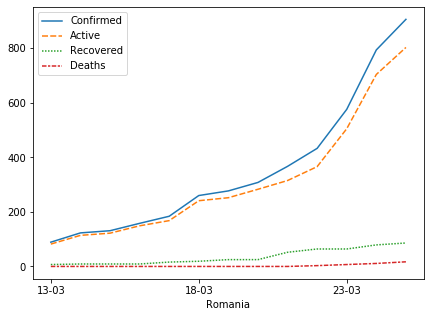


Daily growth for each types of cases



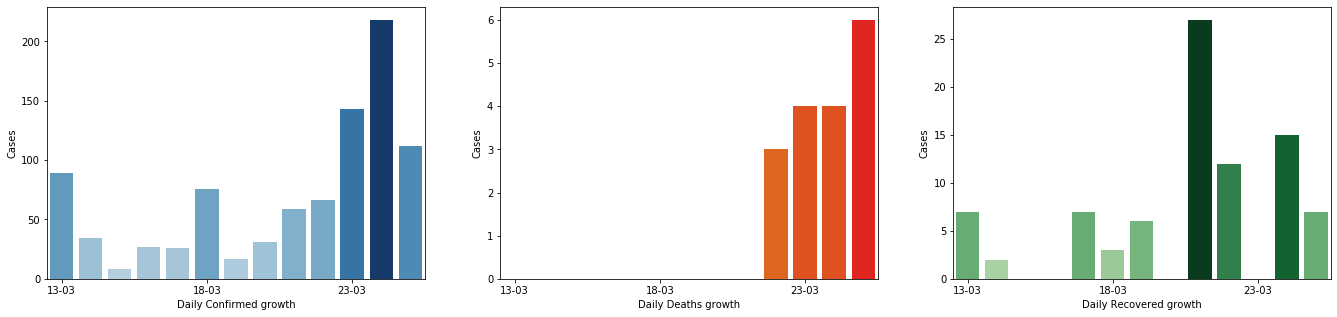

34 . Saudi Arabia
Confirmed: 900 
Active: 869.0 
Recovered: 29.0 
Deaths: 2


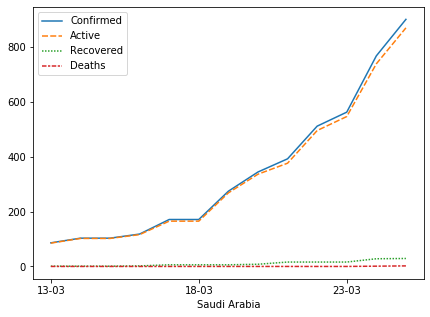


Daily growth for each types of cases



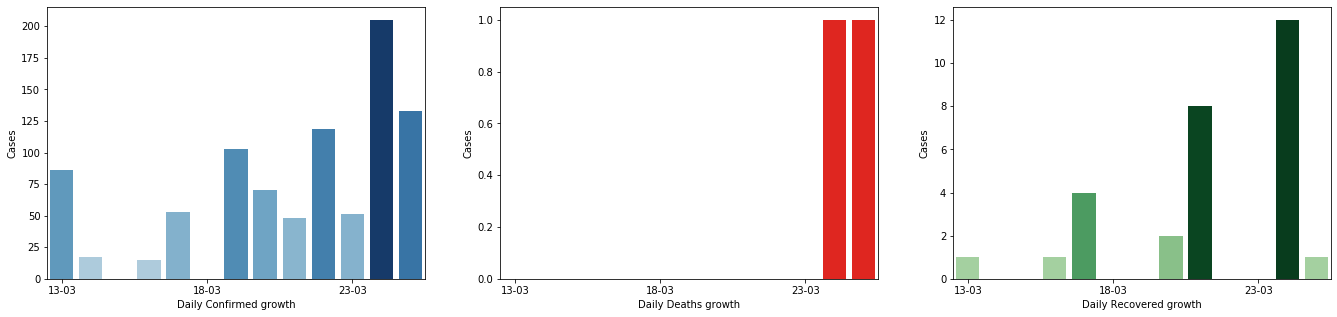

35 . Finland
Confirmed: 880 
Active: 867.0 
Recovered: 10.0 
Deaths: 3


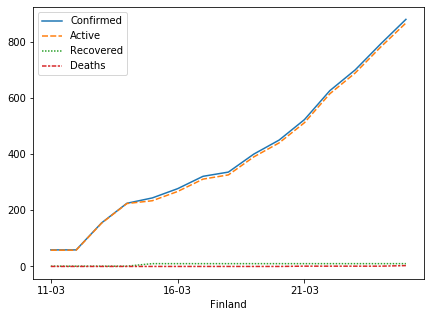


Daily growth for each types of cases



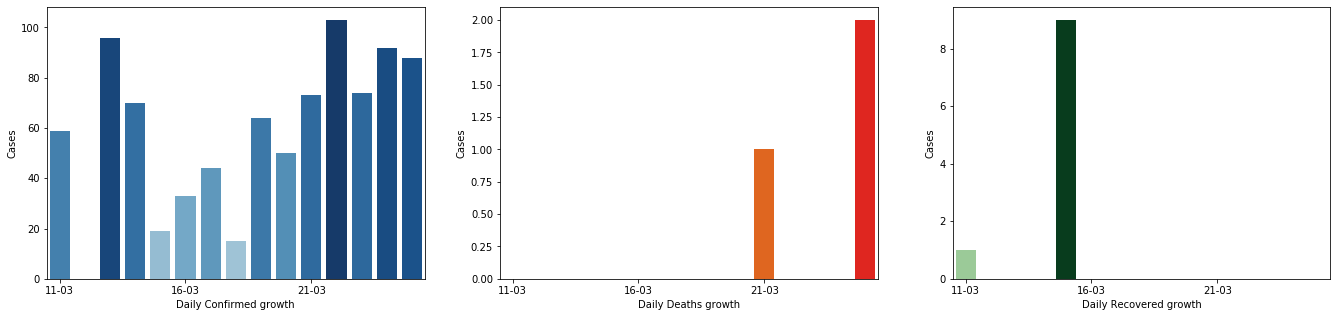

36 . Greece
Confirmed: 821 
Active: 763.0 
Recovered: 36.0 
Deaths: 22


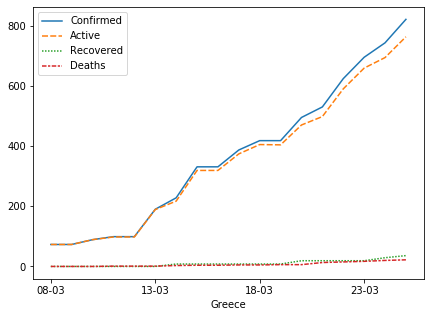


Daily growth for each types of cases



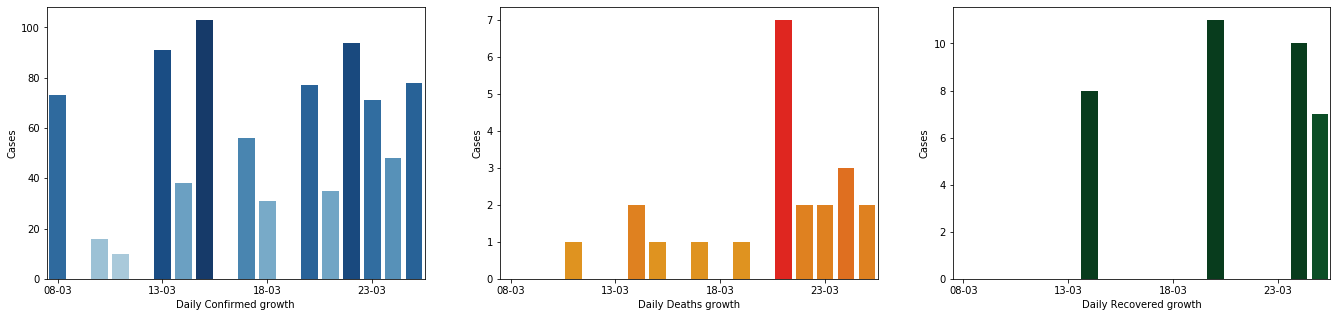

37 . Indonesia
Confirmed: 790 
Active: 701.0 
Recovered: 31.0 
Deaths: 58


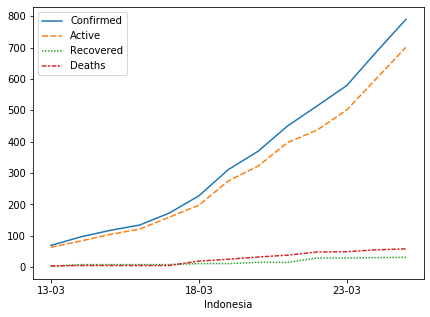


Daily growth for each types of cases



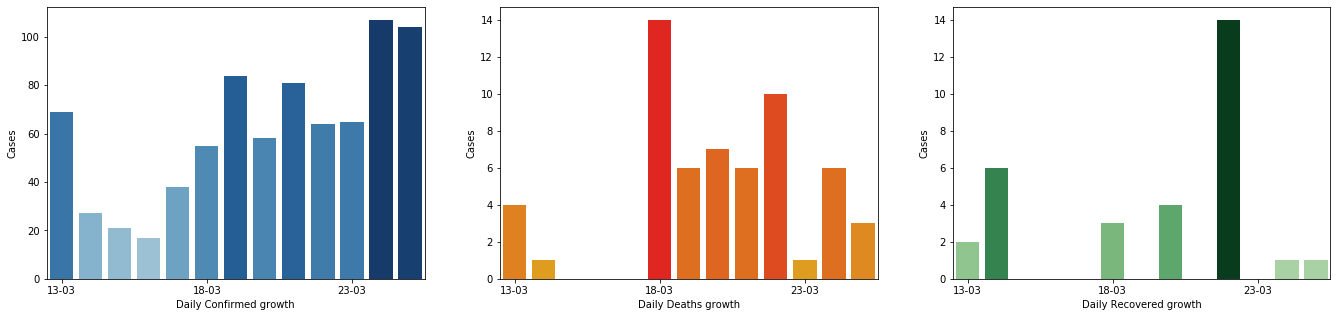

38 . Iceland
Confirmed: 737 
Active: 679.0 
Recovered: 56.0 
Deaths: 2


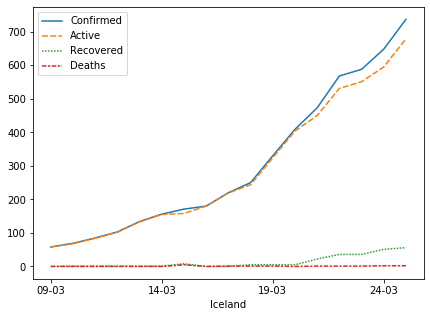


Daily growth for each types of cases



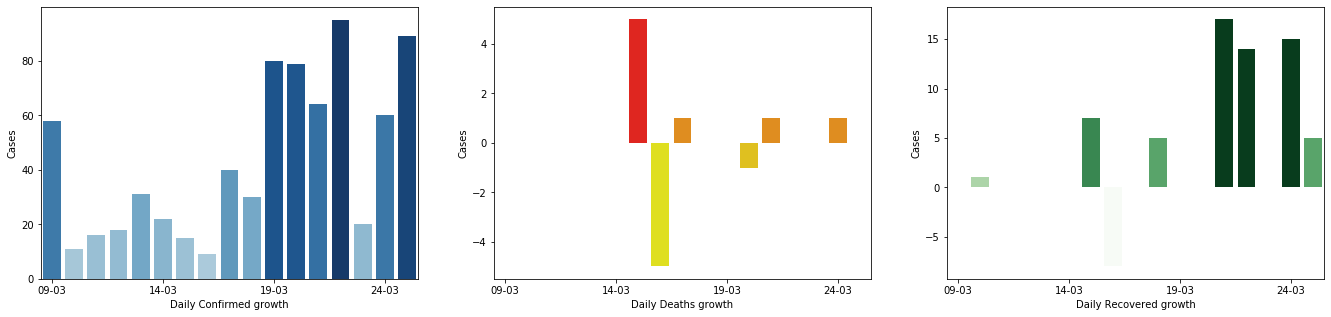

39 . Diamond Princess
Confirmed: 712 
Active: 115.0 
Recovered: 587.0 
Deaths: 10


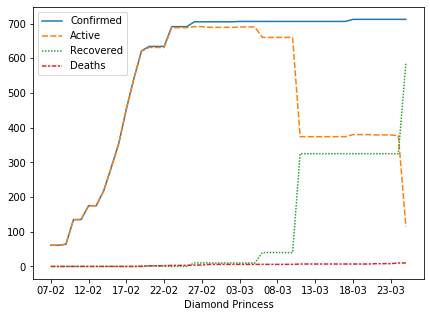


Daily growth for each types of cases



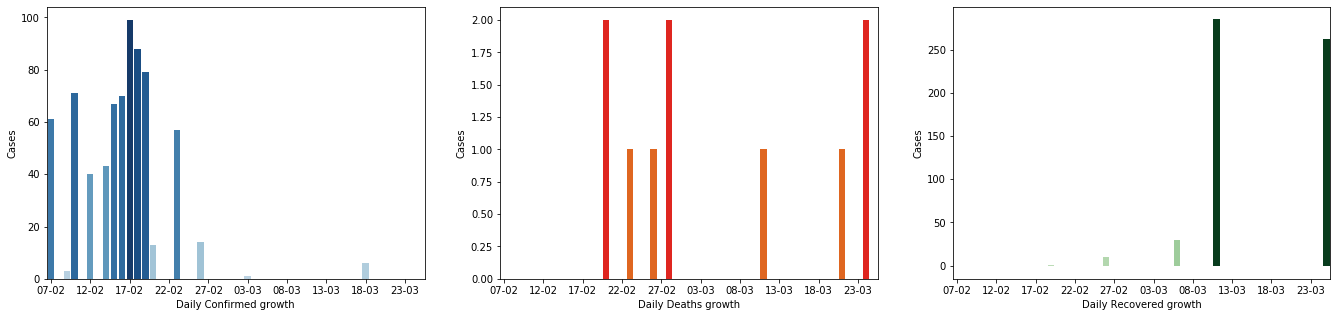

40 . South Africa
Confirmed: 709 
Active: 697.0 
Recovered: 12.0 
Deaths: 0


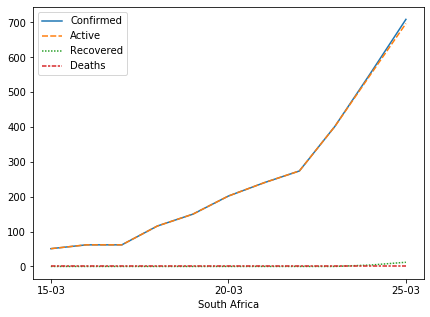


Daily growth for each types of cases



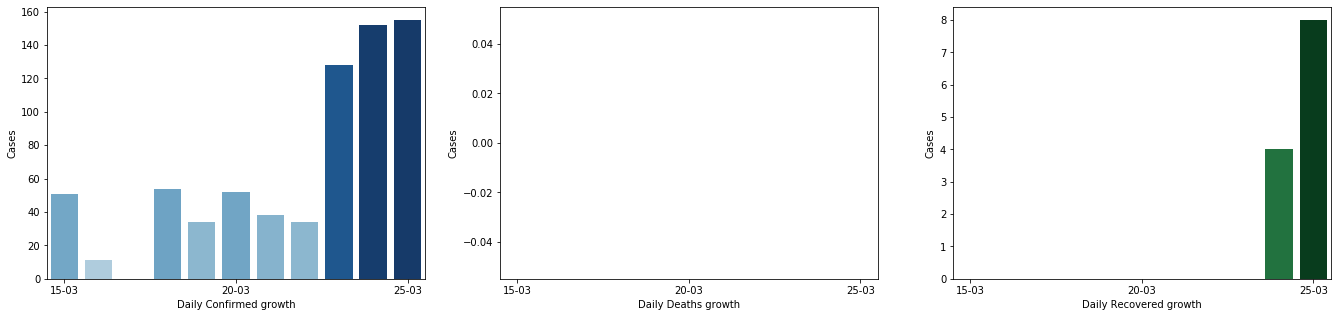

41 . Russia
Confirmed: 658 
Active: 626.0 
Recovered: 29.0 
Deaths: 3


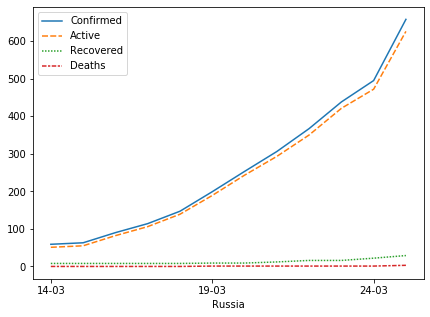


Daily growth for each types of cases



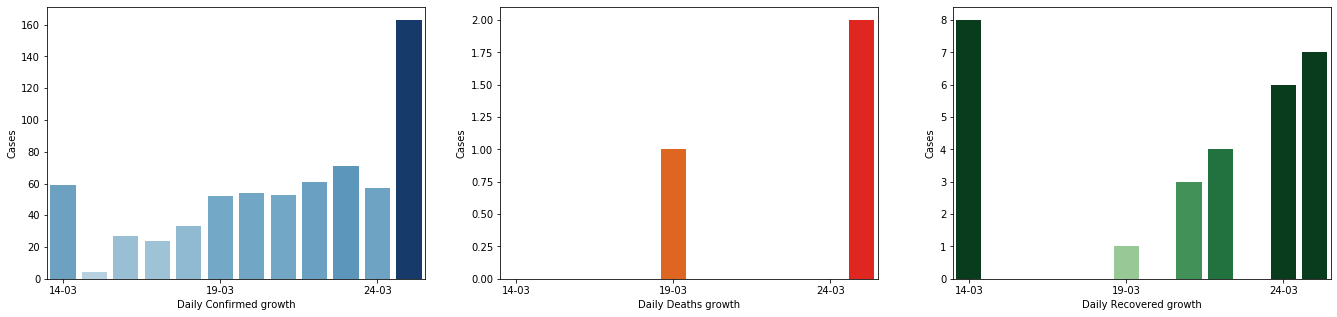

42 . India
Confirmed: 657 
Active: 602.0 
Recovered: 43.0 
Deaths: 12


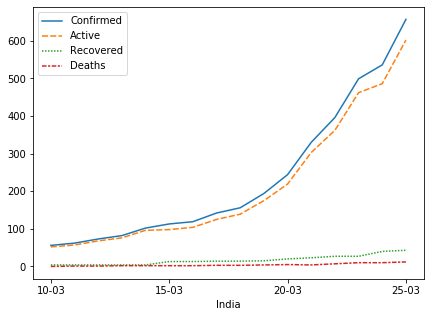


Daily growth for each types of cases



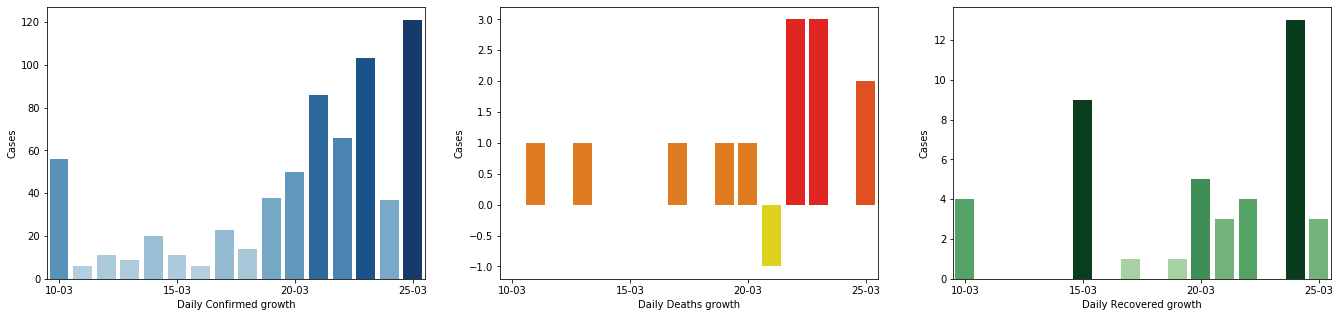

43 . Philippines
Confirmed: 636 
Active: 572.0 
Recovered: 26.0 
Deaths: 38


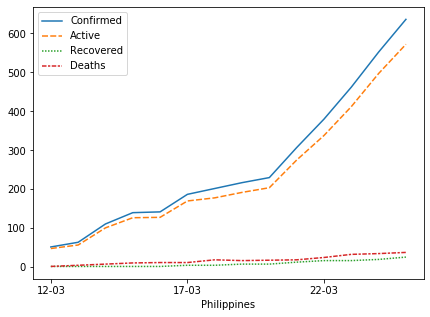


Daily growth for each types of cases



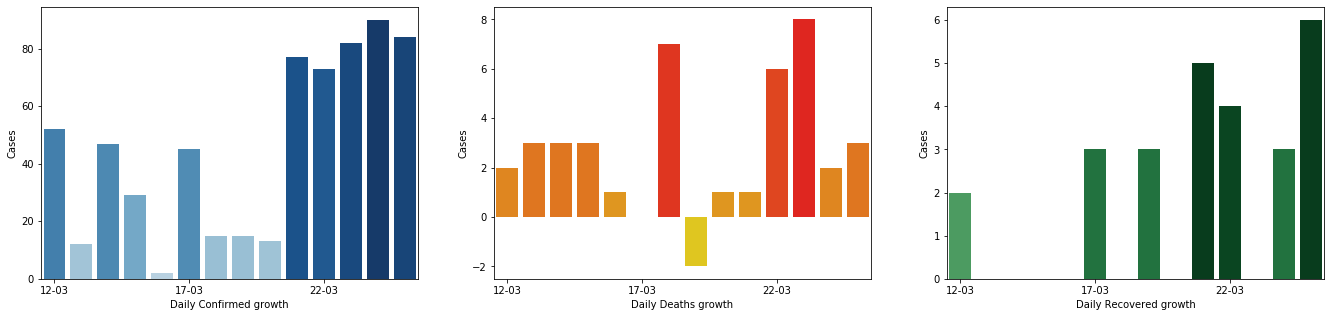

44 . Singapore
Confirmed: 631 
Active: 469.0 
Recovered: 160.0 
Deaths: 2


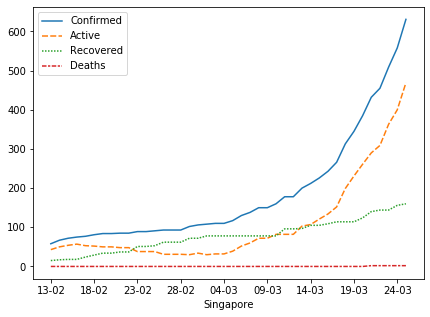


Daily growth for each types of cases



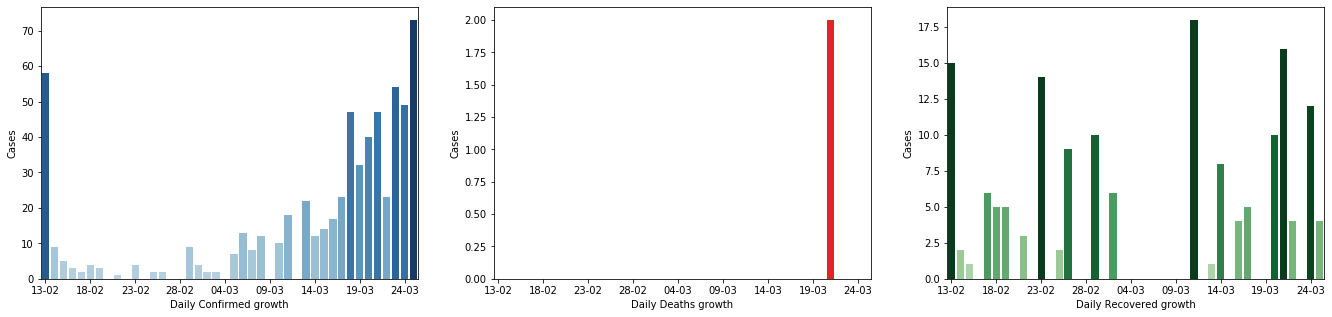

45 . Qatar
Confirmed: 537 
Active: 496.0 
Recovered: 41.0 
Deaths: 0


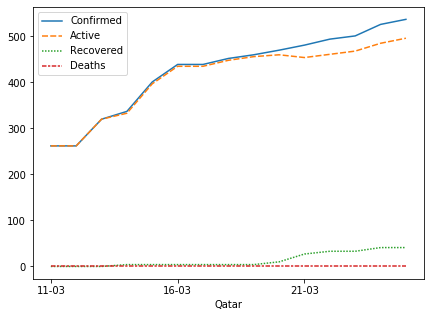


Daily growth for each types of cases



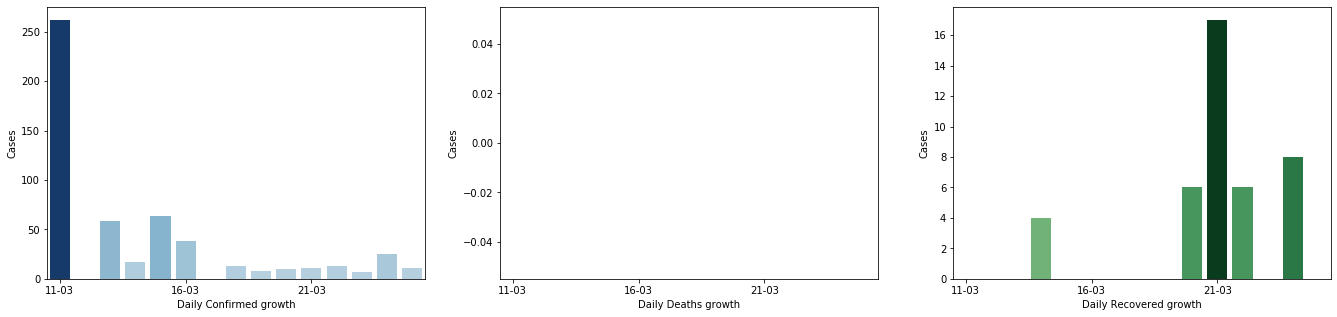

46 . Slovenia
Confirmed: 528 
Active: 513.0 
Recovered: 10.0 
Deaths: 5


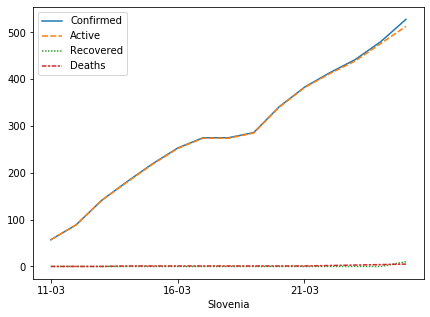


Daily growth for each types of cases



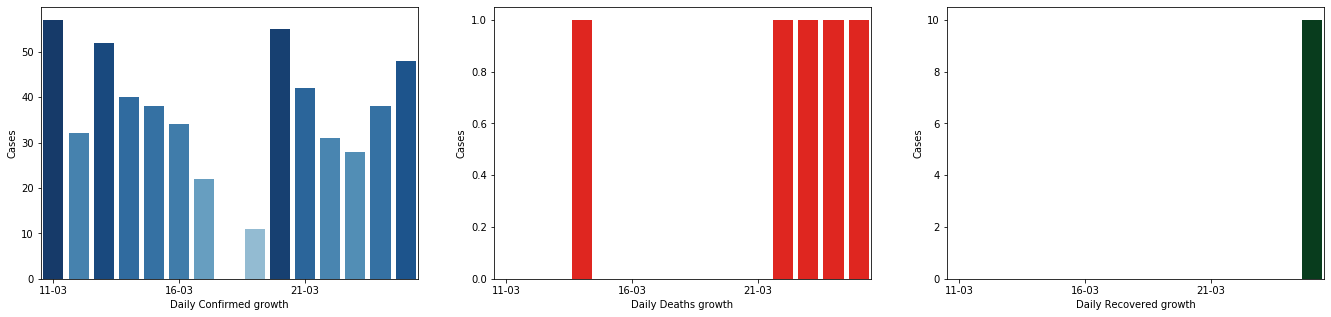

47 . Peru
Confirmed: 480 
Active: 470.0 
Recovered: 1.0 
Deaths: 9


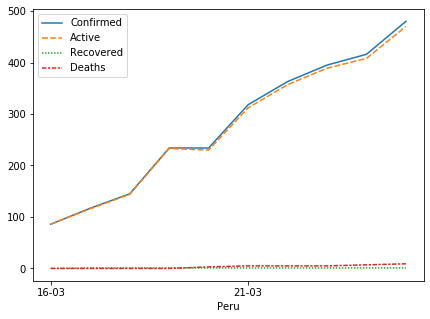


Daily growth for each types of cases



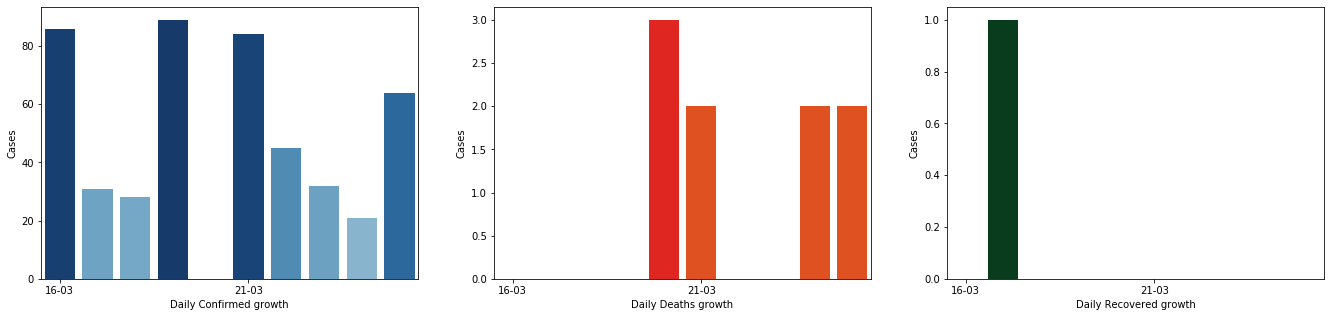

48 . Colombia
Confirmed: 470 
Active: 458.0 
Recovered: 8.0 
Deaths: 4


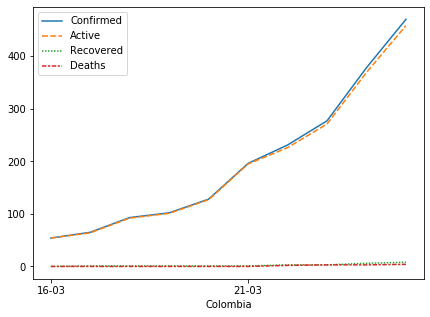


Daily growth for each types of cases



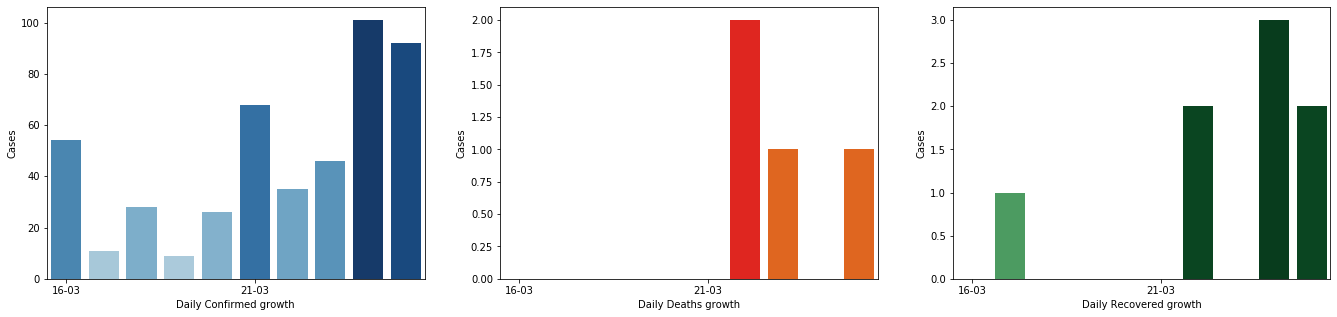

49 . Egypt
Confirmed: 456 
Active: 340.0 
Recovered: 95.0 
Deaths: 21


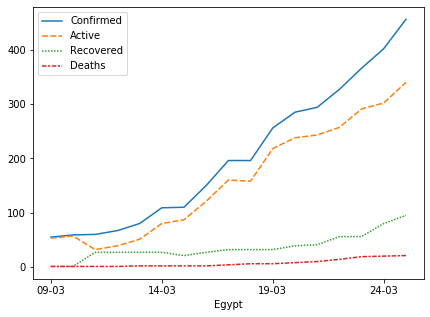


Daily growth for each types of cases



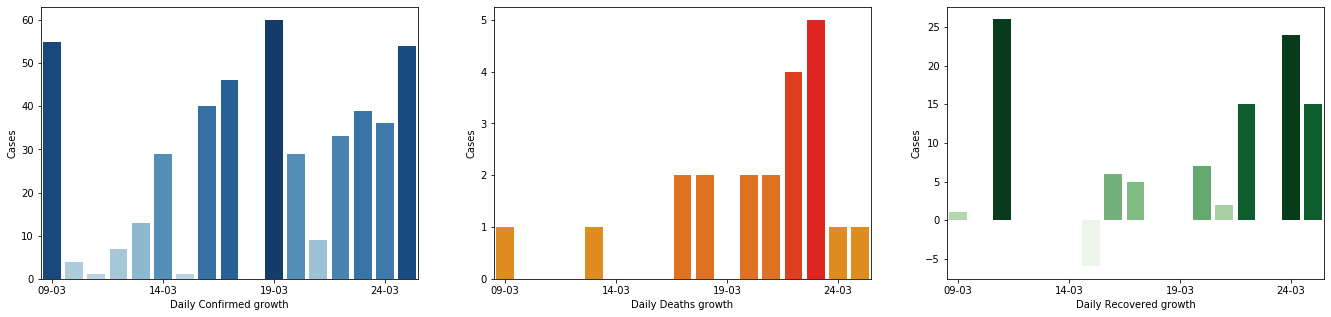

50 . Panama
Confirmed: 443 
Active: 434.0 
Recovered: 1.0 
Deaths: 8


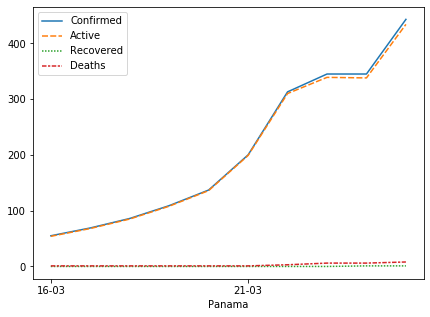


Daily growth for each types of cases



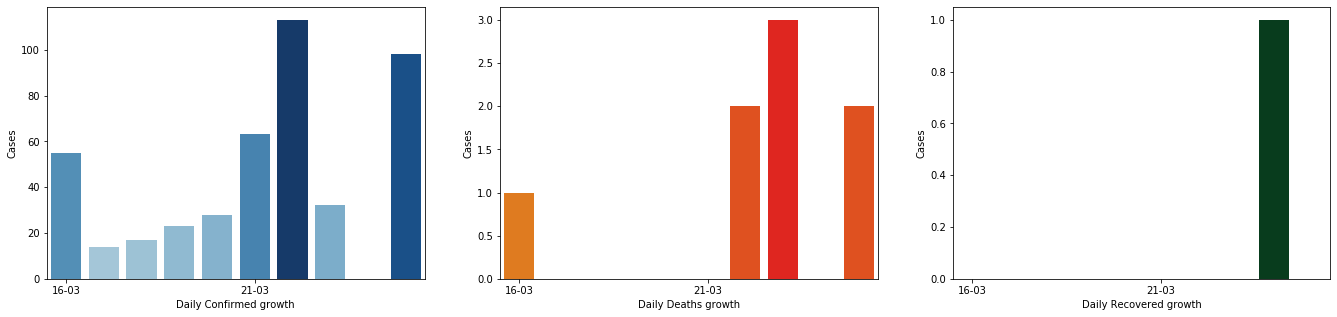

In [17]:
for index, country in enumerate(top_50.index):
    print(index+1,'.', country)
    print('Confirmed:', top_50.Confirmed[country],'\n'\
          'Active:', top_50.Active[country],'\n'\
          'Recovered:', top_50.Recovered[country],'\n'\
          'Deaths:', top_50.Deaths[country]
         )
    df, date_range = prepare_data(covid_19_df, country, 50)
    df = add_data(df)
    show_increment(df, country, date_range)